# Analysis of all BM

In [1]:
# So that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# https://matplotlib.org/stable/users/explain/interactive.html
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# https://matplotlib.org/ipympl/installing.html 
%matplotlib widget

import functions 
from importlib import reload
reload(functions)
from functions import *


Initialisation
Initialisation


## Significance (ok)

### From BMu_values (output of the computation function)

In [33]:
def df_sig_from_BMuvalues(ini_only = False, group_muscle = False,left=False,right=False):
    """
    Arguments:
        ini_only : used the values for the INI session only instead of the ones from INI and REL
        group_muscl : computs the average of the right and left channels
        left : only values of the left channels are used
        right : only values of the right channels are used
    
    """
    # ! when a side is not picked, BMus [44,43,91,42,35,15] won't have value for pRPC and pLPC 
    # and thus won't be taken into account as BMu that are valide for left or right side : fixed 27.07 (if they are valid, they are taken into account for right and left side)
    
    list_p_out = []
    author =''
    error = []

    for BMu,val in BMu_dict_final.items():
        try:
            BMu_nb = int(BMu[3:])
            try:
                author = val[-1]['desc']
            except:
                author = ''
            muscle_l = val[2][0]
            muscle_r= val[2][1]
            BMu_values,_,_  = load_results_presentation(BMu_nb,trial=None,author=author)
            task = val[3]

            # Gait pull Trial !!!
            if task == 'Gait_Normal':
                
                # Grouping columns and applying agg function
                group = BMu_values.groupby(['BM','subject','P_C','session','task','channel'], as_index=False)
                BMu_values = group.agg({'value':np.mean})

                # Joining res column and values
                BMu_values.columns = list(map(''.join, BMu_values.columns.values))            
                print(f'The shape of the table for BMu values is {BMu_values.shape}')



            if ini_only: BMu_values = BMu_values.loc[BMu_values['session']=='INI',:]



            if left and  ((BMu_nb not in [44,43,91,42,35,15]) or (author == '_rl')):
                BMu_values['value'] = BMu_values.loc[BMu_values['channel']==muscle_l,'value']
            
            elif right and  ((BMu_nb not in [44,43,91,42,35,15]) or (author == '_rl')):
                BMu_values['value'] = BMu_values.loc[BMu_values['channel']==muscle_r,'value']

                
                
            if (not group_muscle) and (not left)and (not right)   and ((BMu_nb not in [44,43,91,42,35,15]) or (author == '_rl')):
                RL_bool = True  
            else:
                RL_bool = False
            
            normality = check_normal_distribution_P_C(BMu_values,outlier_present=True,show=False) 

            if True in normality : # initialy False in normality do mannwhitney, changed to match RStudio code and results
                dict_sig = comparison_PC_RL_HLLBP(BMu_values,test="ttest", outlier_present=True,factor=3, show =False, RL = RL_bool )
            else:
                dict_sig = comparison_PC_RL_HLLBP(BMu_values, test='mannwhitneyu', outlier_present=True,factor=3 , show =False, RL = RL_bool)
            pPCo,pRLo,pRLCo,pRLPo,pPCRo,pPCLo = dict_sig[('LBP','C','RL')],dict_sig[('R','L','PC')],dict_sig[('R','L','C')],dict_sig[('R','L','P')],dict_sig[('LBP','C','R')],dict_sig[('LBP','C','L')]

            if True in normality :
                dict_sig = comparison_PC_RL_HLLBP(BMu_values,test="ttest", outlier_present=False,factor=3,show =False, RL =RL_bool)
            else:
                dict_sig = comparison_PC_RL_HLLBP(BMu_values, test='mannwhitneyu', outlier_present=False,factor=3, show =False, RL = RL_bool)

            pPC,pRL,pRLC,pRLP,pPCR,pPCL = dict_sig[('LBP','C','RL')],dict_sig[('R','L','PC')],dict_sig[('R','L','C')],dict_sig[('R','L','P')],dict_sig[('LBP','C','R')],dict_sig[('LBP','C','L')]




            if ((BMu_nb in [44,43,91,42,35,15]) and (author != '_rl')) or (left==True) or (right==True):
                pPCR,pPCL = pPC, pPC
                pPCRo,pPCLo = pPCo, pPCo

            list_p_out += [[BMu,pPCo,pRLo,pRLCo,pRLPo,pPCRo,pPCLo,pPC,pRL,pRLC,pRLP,pPCR,pPCL]]
        
        except Exception as e:
            error += [[BMu,e]]

    df_sig = pd.DataFrame(list_p_out, columns=['BM','pPCo','pRLo','pRLCo','pRLPo','pPCRo','pPCLo','pPC','pRL','pRLC','pRLP','pPCR','pPCL'] )
    df_sig =df_sig.fillna(1)
    df_sig[['pPCob','pRLob','pRLCob','pRLPob','pPCRob','pPCLob','pPCb','pRLb','pRLCb','pRLPb','pPCRb','pPCLb']] = df_sig.iloc[:,1:].transform( lambda x: x <= 0.05 )

    return df_sig,error



In [36]:
df_sig,error = df_sig_from_BMuvalues(ini_only=True,group_muscle=False,left=False,right=False)

c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMu_R = BMu.loc[[True if u[0] == s else False for u in BMu.channel],:]
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_on

The shape of the table for BMu values is (240, 7)
The shape of the table for BMu values is (240, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

The shape of the table for BMu values is (240, 7)
The shape of the table for BMu values is (240, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMu_R = BMu.loc[[True if u[0] == s else False for u in BMu.channel],:]
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_on

The shape of the table for BMu values is (240, 7)
The shape of the table for BMu values is (240, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c

The shape of the table for BMu values is (240, 7)
The shape of the table for BMu values is (240, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  


The shape of the table for BMu values is (240, 7)
The shape of the table for BMu values is (240, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMu_R = BMu.loc[[True if u[0] == s else False for u in BMu.channel],:]
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_on

The shape of the table for BMu values is (238, 7)
The shape of the table for BMu values is (238, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMu_R = BMu.loc[[True if u[0] == s else False for u in BMu.channel],:]
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_on

The shape of the table for BMu values is (238, 7)
The shape of the table for BMu values is (238, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

The shape of the table for BMu values is (240, 7)
The shape of the table for BMu values is (240, 7)


c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMu_R = BMu.loc[[True if u[0] == s else False for u in BMu.channel],:]
c:\Users\Anais\Studio Code\Project 1\nslbp-bio_toolbox2\functions\Biomarker_analysis.py:736: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_on

In [37]:
error,df_sig.shape, df_sig.head(5)

([],
 (50, 25),
       BM      pPCo      pRLo     pRLCo     pRLPo     pPCRo     pPCLo  \
 0   BMu1  0.048413  0.153543  0.191898  0.234922  0.074827  0.036439   
 1  BMu15  0.011228  0.258280  0.941171  0.018597  0.011711  0.005322   
 2  BMu22  0.159785  0.042846  0.128355  0.025495  0.316472  0.229766   
 3  BMu23  0.254751  0.275965  0.421371  0.441368  0.755238  0.561350   
 4  BMu24  0.305751  0.436989  0.265236  0.443528  0.863389  0.436348   
 
         pPC       pRL      pRLC  ...  pRLCob  pRLPob  pPCRob  pPCLob   pPCb  \
 0  0.040095  0.063471  0.114797  ...   False   False   False    True   True   
 1  0.001421  0.077433  0.700815  ...   False    True    True    True   True   
 2  0.269694  0.014695  0.138867  ...   False    True   False   False  False   
 3  0.087002  0.066464  0.011792  ...   False   False   False   False  False   
 4  1.000000  0.085772  0.075448  ...   False   False   False   False  False   
 
     pRLb  pRLCb  pRLPb  pPCRb  pPCLb  
 0  False  False  Fals

In [38]:
df_sum = df_sig.loc[:,['pPCob','pRLob','pRLCob','pRLPob','pPCRob','pPCLob','pPCb','pRLb','pRLCb','pRLPb','pPCRb','pPCLb']].sum()
print(type(df_sum),df_sig.shape,'\n',df_sum)

<class 'pandas.core.series.Series'> (50, 25) 
 pPCob      7
pRLob     10
pRLCob     8
pRLPob    13
pPCRob     4
pPCLob     9
pPCb       8
pRLb      14
pRLCb     12
pRLPb     15
pPCRb      6
pPCLb     11
dtype: int64


In [39]:
df_sum *100/50

pPCob     14.0
pRLob     20.0
pRLCob    16.0
pRLPob    26.0
pPCRob     8.0
pPCLob    18.0
pPCb      16.0
pRLb      28.0
pRLCb     24.0
pRLPb     30.0
pPCRb     12.0
pPCLb     22.0
dtype: float64

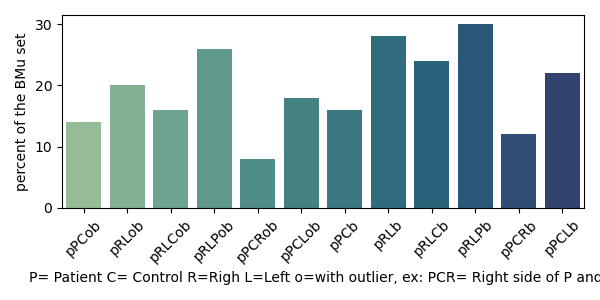

In [40]:
fig,ax = plt.subplots(figsize = (6,3))
sns.barplot(x=df_sum.index,y =df_sum.values*100/df_sig.shape[0],ax=ax,  palette = sns.color_palette("crest", 12) )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='center')
ax.set(xlabel='P= Patient C= Control R=Righ L=Left o=with outlier, ex: PCR= Right side of P and C',ylabel = 'percent of the BMu set')
fig.tight_layout()


In [41]:
# check BM right and left that are valid
print('Right : \n')
print(df_sig.loc[df_sig['pPCRob'] == True ,'BM'].values)
print('\nLeft : \n')
print(df_sig.loc[df_sig['pPCLob'] == True ,'BM'].values)
print('\npulled : \n')
print(df_sig.loc[df_sig['pPCob'] == True ,'BM'].values)

Right : 

['BMu15' 'BMu42' 'BMu44' 'BMu68']

Left : 

['BMu1' 'BMu15' 'BMu29' 'BMu34' 'BMu36' 'BMu38' 'BMu42' 'BMu43' 'BMu44']

pulled : 

['BMu1' 'BMu15' 'BMu36' 'BMu42' 'BMu44' 'BMu113' 'BMu115']


In [43]:
# BMu that have a significant difference between RL value
out = 'o' # 'o' = with outliers
print('difference R/L LBP : \n')
print(df_sig.loc[df_sig[f'pRLP{out}b'] == True ,'BM'].values)
print(' \ndifference R/L AS : \n')
print(df_sig.loc[df_sig[f'pRLC{out}b'] == True ,'BM'].values)
print(' \ndifference R/L  AS&LBP : \n')
print(df_sig.loc[df_sig[f'pRL{out}b'] == True ,'BM'].values)

difference R/L LBP : 

['BMu15' 'BMu22' 'BMu29' 'BMu34' 'BMu36' 'BMu38' 'BMu67' 'BMu69' 'BMu96'
 'BMu97' 'BMu115' 'BMu117' 'BMu118']
 
difference R/L AS : 

['BMu44' 'BMu51' 'BMu53' 'BMu67' 'BMu96' 'BMu105' 'BMu117' 'BMu118']
 
difference R/L  AS&LBP : 

['BMu22' 'BMu42' 'BMu44' 'BMu67' 'BMu69' 'BMu96' 'BMu100' 'BMu105'
 'BMu117' 'BMu118']


In [44]:
def get_muscle(list_BMu):
    list_muscle = []
    for bm in list_BMu:
       BMu_nb = bm[3:]
       _,_,muscles,task, _,_,_,_,_,_ = BMu_dict_final['BMu'+str(BMu_nb)]
       list_muscle += [muscles[0][2:]]

    return list_muscle

In [45]:
list_muscle_RL_LBP = get_muscle(df_sig.loc[df_sig['pRLPb'] == True ,'BM'].values)
list_muscle_RL_AS = get_muscle(df_sig.loc[df_sig['pRLCb'] == True ,'BM'].values)
list_muscle_RL_LBP,list_muscle_RL_AS

(['LES',
  'LES',
  'MTF',
  'MTF',
  'MTF',
  'MTF',
  'ESI',
  'LES',
  'ESI',
  'EO',
  'LES',
  'ESI',
  'MTF',
  'LES',
  'LES'],
 ['ESI',
  'LES',
  'MTF',
  'MTF',
  'ESI',
  'ESI',
  'LES',
  'ESI',
  'ESI',
  'LES',
  'LES',
  'LES'])

In [46]:
df_val_p = df_sig.loc[:,['BM','pPCLo']]

In [47]:
df_val_p=df_val_p.rename(columns={'pPCLo':'P','BM':'Biomarkers'})

In [48]:
df_val_p['Biomarkers'] = df_val_p['Biomarkers'].apply(lambda x: f'BMo{x[3:]}' ) 
                                               

In [49]:
df_val_p.shape, df_val_p.head(5)

((50, 2),
   Biomarkers         P
 0       BMo1  0.036439
 1      BMo15  0.005322
 2      BMo22  0.229766
 3      BMo23  0.561350
 4      BMo24  0.436348)

In [50]:
np.sum(df_val_p ['P']<= 0.05)

9

In [51]:
df_val_p.loc[df_val_p ['P']<= 0.05,'Biomarkers']

0      BMo1
1     BMo15
5     BMo29
6     BMo34
8     BMo36
10    BMo38
13    BMo42
14    BMo43
15    BMo44
Name: Biomarkers, dtype: object

In [52]:
df_val_p.loc[df_val_p ['Biomarkers']== 'BMo38',:]

Biomarkers         P
10      BMo38  0.045269

### From input validity

In [53]:
def df_validity_from_input_val():
    # ! the valid BMu for left side INI are the same and have similar values as with RStudio ! except BMu29 and BMu 38: ?
    
    all_files = glob("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\Neblett rl\\left_side\\Input_validity\\*.csv")
    dict_validity = {'Biomarkers':[],'P':[],'Normality':[]}
    for path in all_files:
        df_val_input = pd.read_csv(path)
        BMu_nb = os.path.split(path)[1][:-4]

        normality = check_normal_distribution_input_val(df_val_input,outlier_present=True,show=False) 
        if True in normality :
            p_PC = comparison_PC_input_val(df_val_input, test = 'ttest')
        else:
            p_PC = comparison_PC_input_val(df_val_input, test = 'mannwhitneyu')

        dict_validity['Biomarkers'] += [BMu_nb]
        dict_validity['P'] += [p_PC]
        dict_validity['Normality'] += [normality]

    df_val = pd.DataFrame(dict_validity)
    return df_val



In [54]:
df_val = df_validity_from_input_val()
df_val.head(5)

Biomarkers         P       Normality
0       BMo1  0.036439  [False, False]
1     BMo100  0.871486    [True, True]
2     BMo101  0.607692   [False, True]
3     BMo102  0.510598  [False, False]
4     BMo103  0.169491   [False, True]

In [55]:
df_val.loc[df_val['P']<=0.05,:]

Biomarkers         P       Normality
0        BMo1  0.036439  [False, False]
20      BMo15  0.005322  [False, False]
24      BMo29  0.042221   [True, False]
25      BMo34  0.004838   [True, False]
27      BMo36  0.000160    [True, True]
29      BMo38  0.045269   [True, False]
32      BMo42  0.002729   [False, True]
33      BMo43  0.036439  [False, False]
34      BMo44  0.000306   [False, True]

In [56]:
df_val.loc[df_val['Biomarkers']=='BMo38',:]# same number as with BMu_values

Biomarkers         P      Normality
29      BMo38  0.045269  [True, False]

In [57]:
df_val.loc[df_val['Biomarkers']=='BMo29',:] # same number as with BMu_values

Biomarkers         P      Normality
24      BMo29  0.042221  [True, False]

### Comparison with RStudio

In [58]:
df_rs_val = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\Neblett rl\\left_side\\Output_validity\\Validity.csv").drop('Unnamed: 0',axis=1)
df_rs_val['Biomarkers'] = df_rs_val['Biomarkers'].apply(lambda x: x[:-4])
df_rs_val.shape,df_rs_val.head(5)

((50, 6),
   Biomarkers  Unit     Normality         P        AUC     Youden
 0       BMo1     V  1.141144e-14  0.035767  65.777778  40.000000
 1     BMo100  %MAX  5.788438e-01  0.871504  52.555556  13.333333
 2     BMo101  %MAX  5.743075e-04  0.449212  55.777778  20.000000
 3     BMo102  %MAX  8.876892e-04  0.513348  45.000000  13.333333
 4     BMo103  %MAX  1.662156e-03  0.335396  57.333333  30.000000)

In [59]:
sum_valide_BM = np.sum(df_rs_val['P']<=0.05)
percent_valide_BM = sum_valide_BM/df_rs_val.shape[0]*100
print(f'There are {sum_valide_BM} valid BMus which represents {percent_valide_BM}% of the 50 studied BMus')

There are 9 valid BMus which represents 18.0% of the 50 studied BMus


In [60]:
df_rs_val.loc[df_rs_val['P']<=0.05,:]

Biomarkers      Unit     Normality         P        AUC     Youden
0        BMo1         V  1.141144e-14  0.035767  65.777778  40.000000
20      BMo15         V  6.053464e-11  0.004757  71.000000  40.000000
24      BMo29        Hz  9.691761e-02  0.042633  60.666667  30.000000
25      BMo34      %MAX  6.163663e-03  0.001063  74.367816  42.873563
27      BMo36  %SubMVIC  5.024039e-01  0.000165  77.222222  50.000000
29      BMo38        Hz  1.870575e-01  0.046058  59.444444  33.333333
32      BMo42       NAN  5.024203e-05  0.000175  77.444444  53.333333
33      BMo43       NAN  1.264834e-06  0.035767  65.777778  40.000000
34      BMo44       NAN  9.156119e-02  0.000306  76.444444  46.666667

In [61]:
df_rs_val.loc[df_rs_val['Biomarkers']=='BMo38',:]

Biomarkers Unit  Normality         P        AUC     Youden
29      BMo38   Hz   0.187058  0.046058  59.444444  33.333333

In [62]:
BMu_values,_,_  = load_results_presentation(38,trial=None,author='')
BMu_values = BMu_values.loc[BMu_values['session']=='INI',:]
BMu_values = BMu_values.loc[BMu_values['channel']==BMu_values['channel'].unique()[0],:]

BMu_P = BMu_values.loc[BMu_values['P_C']=='P']['value'].dropna()

BMu_C = BMu_values.loc[BMu_values['P_C']=='C']['value'].dropna()

mannwhitneyu(BMu_P, BMu_C,alternative='two-sided')[1] ,ttest_ind(BMu_P, BMu_C,alternative='two-sided')[1]#ttest_ind mannwhitneyu 
# some results differs because the used test is not the same

(0.21156123692597317, 0.045268949884022774)

In [63]:
df_rs_val.loc[df_rs_val['Biomarkers']=='BMo29',:]

Biomarkers Unit  Normality         P        AUC  Youden
24      BMo29   Hz   0.096918  0.042633  60.666667    30.0

In [64]:
df_all_val = df_val_p.merge(df_rs_val.loc[:,['Biomarkers','P']],how ='right',on='Biomarkers')

In [68]:
df_rs_val.loc[21:25,['Biomarkers','P']].head(5),df_val_p.head(5)

(   Biomarkers         P
 21      BMo22  0.231878
 22      BMo23  0.564232
 23      BMo24  0.439339
 24      BMo29  0.042633
 25      BMo34  0.001063,
   Biomarkers         P
 0       BMo1  0.036439
 1      BMo15  0.005322
 2      BMo22  0.229766
 3      BMo23  0.561350
 4      BMo24  0.436348)

In [69]:
df_all_val.loc[20:25,:]

Biomarkers       P_x       P_y
20      BMo15  0.005322  0.004757
21      BMo22  0.229766  0.231878
22      BMo23  0.561350  0.564232
23      BMo24  0.436348  0.439339
24      BMo29  0.042221  0.042633
25      BMo34  0.004838  0.001063

In [70]:
df_all_val = df_all_val.rename(columns={'P_x':'P_p','P_y':'P_r'})

In [71]:
df_all_val.head(5)

Biomarkers       P_p       P_r
0       BMo1  0.036439  0.035767
1     BMo100  0.871486  0.871504
2     BMo101  0.607692  0.449212
3     BMo102  0.510598  0.513348
4     BMo103  0.169491  0.335396

In [72]:
df_val = df_validity_from_input_val()
df_val.head(5),np.sum(df_val['P']<=0.05),np.sum(df_rs_val['P']<=0.05)

(  Biomarkers         P       Normality
 0       BMo1  0.036439  [False, False]
 1     BMo100  0.871486    [True, True]
 2     BMo101  0.607692   [False, True]
 3     BMo102  0.510598  [False, False]
 4     BMo103  0.169491   [False, True],
 9,
 9)

In [73]:
df_val.loc[df_val['P']<=0.05,'Biomarkers'],df_rs_val.loc[df_rs_val['P']<=0.05,'Biomarkers'] # Valid BM in Python and RS results

(0      BMo1
 20    BMo15
 24    BMo29
 25    BMo34
 27    BMo36
 29    BMo38
 32    BMo42
 33    BMo43
 34    BMo44
 Name: Biomarkers, dtype: object,
 0      BMo1
 20    BMo15
 24    BMo29
 25    BMo34
 27    BMo36
 29    BMo38
 32    BMo42
 33    BMo43
 34    BMo44
 Name: Biomarkers, dtype: object)

In [74]:
df_val.head(3),df_rs_val.head(3)

(  Biomarkers         P       Normality
 0       BMo1  0.036439  [False, False]
 1     BMo100  0.871486    [True, True]
 2     BMo101  0.607692   [False, True],
   Biomarkers  Unit     Normality         P        AUC     Youden
 0       BMo1     V  1.141144e-14  0.035767  65.777778  40.000000
 1     BMo100  %MAX  5.788438e-01  0.871504  52.555556  13.333333
 2     BMo101  %MAX  5.743075e-04  0.449212  55.777778  20.000000)

In [76]:
abs(df_all_val['P_p']-df_all_val['P_r']).sort_values(ascending=False) # differences between p value computed with Python and with RStudio

12    6.067111e-01
48    2.397592e-01
43    2.002820e-01
4     1.659050e-01
2     1.584798e-01
9     1.521264e-01
5     1.179541e-01
19    9.355570e-02
40    3.059338e-02
25    3.775724e-03
23    2.990789e-03
22    2.882268e-03
13    2.842677e-03
45    2.787451e-03
3     2.750130e-03
46    2.699587e-03
39    2.591781e-03
32    2.554364e-03
14    2.491386e-03
36    2.173865e-03
21    2.111877e-03
38    2.096491e-03
31    2.021565e-03
42    2.003312e-03
35    1.983364e-03
41    1.732840e-03
11    1.653635e-03
18    8.090643e-04
29    7.892195e-04
33    6.717306e-04
0     6.717306e-04
26    6.621748e-04
20    5.647505e-04
37    5.167106e-04
44    4.447985e-04
17    4.288241e-04
24    4.118928e-04
10    3.910851e-04
7     2.227145e-04
8     2.014420e-04
49    1.671540e-04
16    1.562851e-04
15    1.122114e-04
47    9.395605e-05
1     1.830756e-05
6     1.437094e-05
27    4.903917e-06
28    3.489568e-06
30    1.993903e-07
34    1.207143e-07
dtype: float64

In [77]:
np.sum(df_all_val['P_p']<df_all_val['P_r'])

36

In [78]:
np.sum(df_all_val['P_p']<=0.05)

9

In [79]:
np.sum(df_all_val['P_r']<=0.05)

9

## Right left (ok)

In [ ]:
df_lbp_rl = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\right_left\\Output_P\\P_Value.csv")
df_as_rl = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\right_left\\Output_C\\P_Value.csv")
df_as_rl =df_as_rl.drop(columns="Unnamed: 0")	
df_lbp_rl =df_lbp_rl.drop(columns="Unnamed: 0")	
df_as_rl['Biomarkers'] =df_as_rl['Biomarkers'].apply(lambda x: x[:-4])
df_lbp_rl['Biomarkers'] =df_lbp_rl['Biomarkers'].apply(lambda x: x[:-4])
# For the two-sample dependent case, the null hypothesis is that the median for the differences of the populations from which x and y are drawn is mu

In [ ]:
df_lbp_rl['sig'] = df_lbp_rl['P']<=0.05
df_as_rl['sig'] = df_as_rl['P']<=0.05
# BMu for which the difference between sides is significant = True

In [ ]:
df_lbp_rl.head(3)

In [ ]:
df_as_rl.head(3)

### AS Participants

In [ ]:
df_as_rl.loc[df_as_rl['sig']==True,'Biomarkers']

In [ ]:
df_as_rl.loc[df_as_rl['sig']==True,'Biomarkers'].shape[0]*100/df_as_rl.shape[0] # percent of BM with diff btw sides

### LBP Participants

In [ ]:
df_lbp_rl.loc[df_lbp_rl['sig']==True,'Biomarkers']

In [ ]:
df_lbp_rl.loc[df_lbp_rl['sig']==True,'Biomarkers'].shape[0]*100/df_lbp_rl.shape[0] # percent of BM with diff btw sides

In [ ]:
diff_lbp_as = list(df_as_rl.loc[df_as_rl['sig']==True,'Biomarkers'].values)
for x in df_lbp_rl.loc[df_lbp_rl['sig']==True,'Biomarkers'].values:
    if x not in diff_lbp_as:
        diff_lbp_as.append(x)

In [ ]:
diff_lbp_as, len(diff_lbp_as),len(diff_lbp_as)*100 / df_as_rl.shape[0]

## Validity Inequalities between AS and LLBP/HLBP (ok)

Display the difference betweem the mean of AS Participants and the mean of LLBP Participants or HLBP Participants
The inequalities between AS-LLBP and AS-HLBP are not the same for some BMu (see BMu 102, 103 ...)

In [ ]:
dict_HLLBP_BM = {'BM':[],'AS':[],'LLBP':[],'HLBP':[]}
dict_sns = {'BM':[],'Value':[],'Group':[]}
detailed = False
left=True

for BM_name,val in BMu_dict_final.items():
    
    nb_BM = int(BM_name[3:])

    try:
        desc = val[-1]['desc']
    except:
        desc=''
    muscle = val[2]

    BMu_values,_,_ = load_results_presentation(nb_BM,trial=None,author=desc)

    if left and nb_BM not in [[44,43,91,42,35,15]]:
        BMu_values = BMu_values.loc[BMu_values['channel']== muscle[0],:]

    BMu_values['AS'] = BMu_values['subject'].apply( lambda x: 1 if x in SUBJECT_C else 0) 
    BMu_values['HLBP'] = BMu_values['subject'].apply( lambda x: 1 if x in SUBJECT_HLBP else 0) 
    BMu_values['LLBP'] = BMu_values['subject'].apply( lambda x: 1 if x in SUBJECT_LLBP else 0) 
 
    if detailed:
        for g in ['LLBP','HLBP']:
            dict_HLLBP_BM[g] += [(BMu_values.loc[BMu_values[g]==1,'value'].mean()-BMu_values.loc[BMu_values['AS']==1,'value'].mean())*100/BMu_values.loc[BMu_values['AS']==1,'value'].mean()]
            dict_sns['Group'] += [g]*BMu_values.loc[BMu_values[g]==1,'value'].shape[0]
            dict_sns['BM'] += [nb_BM]*BMu_values.loc[BMu_values[g]==1,'value'].shape[0]
            dict_sns['Value'] += list((BMu_values.loc[BMu_values[g]==1,'value'].values-BMu_values.loc[BMu_values['AS']==1,'value'].mean())*100/BMu_values.loc[BMu_values['AS']==1,'value'].mean())
        dict_HLLBP_BM['BM'] += [nb_BM]

    else:
        for g in ['LLBP','HLBP']:
            dict_HLLBP_BM[g] += [(BMu_values.loc[BMu_values[g]==1,'value'].mean()-BMu_values.loc[BMu_values['AS']==1,'value'].mean())*100/BMu_values.loc[BMu_values['AS']==1,'value'].mean()]
            dict_sns['Group'] += [g]
            dict_sns['BM'] += [nb_BM]
            dict_sns['Value'] += [(BMu_values.loc[BMu_values[g]==1,'value'].mean()-BMu_values.loc[BMu_values['AS']==1,'value'].mean())*100/BMu_values.loc[BMu_values['AS']==1,'value'].mean()]
        dict_HLLBP_BM['BM'] += [nb_BM]



In [ ]:
fig,ax = plt.subplots(figsize = (13,5))
df_sns = pd.DataFrame(dict_sns)
sns.barplot(x=df_sns['BM'],y=df_sns['Value'],hue=df_sns['Group'],ax=ax,errwidth=0.5)
ax.set(title="Mean of group values - mean of AS values normalized with the mean of AS values")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')

# ax.set_ylim(-100,100)

In [ ]:
df_sns

In [ ]:
np.sum(df_sns.loc[df_sns['Group']=='HLBP','Value'].values>=df_sns.loc[df_sns['Group']=='LLBP','Value'].values)

In [ ]:
np.sum(df_sns.loc[df_sns['Group']=='HLBP','Value'].values<df_sns.loc[df_sns['Group']=='LLBP','Value'].values)

## Some plots of the score of the measurement properties of the BMu

### Reliability

In [ ]:
df_rel = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\one_side_reliability\\Ouput_reliability\\Reliability.csv").drop('Unnamed: 0',axis=1)
df_rel.head(5)

In [ ]:
df_rel.describe()

In [ ]:
ICC_score = {0.9:'Excellent',0.75:'Good',0.5:'Moderate',0:'Poor'} #sup # max
SEM_score = {0:'Excellent',16.5:'Good',33:'Moderate',50:'Poor'} #sup strict #min
col_ICC = ['ICC_intra','ICC_testretest']
col_SEM = ['SEMp_intra','SEMp_testretest']
for col in col_ICC:
    df_rel[f'{col}_score'] = df_rel[col].apply(lambda x:  ICC_score[np.nanmax([k if x>=k else np.NAN for k in list(ICC_score.keys())] )] )
for col in col_SEM:
    df_rel[f'{col}_score'] = df_rel[col].apply(lambda x:  SEM_score[np.nanmax([k if x>k else np.NAN for k in list(SEM_score.keys())] )] )


In [ ]:
df_rel.head(3)

In [ ]:
for sc_n in ['ICC_intra_score','ICC_testretest_score','SEMp_intra_score','SEMp_testretest_score']:
    for sc in ['Excellent','Good','Moderate']:
        print(f'{sc_n} {sc} : {df_rel.loc[df_rel[sc_n]==sc].shape[0]} : {df_rel.loc[df_rel[sc_n]==sc,"Biomarkers"].values}')

In [ ]:
df_rel_group = df_rel.copy(deep=True)

In [ ]:
df_rel_group[['Group', 'Biomarkers']] = df_rel_group["Biomarkers"].apply(lambda x: pd.Series(str(x).split("_")))


In [ ]:
df_rel_group.shape,df_rel.shape

In [ ]:
df_rel_group.head(3)

In [ ]:
plot_rating_measurement(df_rel_group,'SEMp_intra',max_h=90,pc=False)

In [ ]:
plot_rating_measurement(df_rel_group,'SEMp_intra',max_h=50,pc=True)  # bar heights sum to 100 %

In [ ]:
for x in [29,34,36,44]:
    print(df_rel_group.loc[df_rel_group['Biomarkers']==f'BMo{x}.csv',['Biomarkers','ICC_intra_score','SEMp_intra_score']])

### Interpretatbility

In [ ]:
df_int = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\one_side_reliability\\Ouput_reliability\\Interpretability.csv").drop('Unnamed: 0',axis=1)
df_int.shape,df_int.head(5)

In [ ]:
df_int.describe()

In [ ]:
MDC_score = {0:'Excellent',16.5:'Good',33:'Moderate',50:'Poor'} #sup strict #min
col_MDC = ['MDCp_intra','MDCp_testretest']
for col in col_MDC:
    df_int[f'{col}_score'] = df_int[col].apply(lambda x:  MDC_score[np.nanmax([k if x>=k else np.NAN for k in list(MDC_score.keys())] )] )


In [ ]:
df_int.head(3)

In [ ]:
df_int_group = df_int.copy(deep=True)
df_int_group[['Group', 'Biomarkers']] = df_int_group["Biomarkers"].apply(lambda x: pd.Series(str(x).split("_")))

print(df_int_group.shape,df_int.shape)
print(df_int_group.head(3))

In [ ]:
for sc_n in ['MDCp_intra_score','MDCp_testretest_score']:
    for sc in ['Excellent','Good','Moderate']:
        print(f'{sc_n} {sc} : {df_int.loc[df_int[sc_n]==sc].shape[0]} : {df_int.loc[df_int[sc_n]==sc,"Biomarkers"].values}')


In [ ]:
plot_rating_measurement(df_int_group,'MDCp_testretest',max_h=50,pc=True)

In [ ]:
for x in [29,34,36,44,117]:
    print(df_int_group.loc[df_int_group['Biomarkers']==f'BMo{x}.csv',['Biomarkers','Group','MDCp_testretest','MDCp_testretest_score']])

In [ ]:
BMu_values,_,_ = load_results_presentation(44)
BMu_values = BMu_values.loc[BMu_values['session']=='INI',:]
BMu_values = BMu_values.loc[BMu_values['P_C']=='P']
BMu_values.head(3)

In [ ]:
BMu_values['value'].mean()* 74/100

In [ ]:
plt.close('all')
fig, ax = plt.subplots(figsize = [9,4])
sns.boxplot(data=BMu_values,x='value', ax= ax,showmeans=True,
        meanprops={"marker": "+",
                    "markeredgecolor": "black",
                    "markersize": "10"})
sns.swarmplot([BMu_values['value'].mean()+ BMu_values['value'].mean()* 122/100,(BMu_values['value'].mean()- BMu_values['value'].mean()* 122/100)],ax=ax,color='red')
ax.set(xlabel=f'values (Hz) ', title = 'Boxplot of BMu values')

fig.tight_layout()

### Validity

In [ ]:
# "C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\Output_validity\\Validity.csv"
df_rs_val = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\onsided\\Output_validity\\Validity.csv").drop('Unnamed: 0',axis=1)
df_rs_val['Biomarkers'] = df_rs_val['Biomarkers'].apply(lambda x: x[:-4])
df_rs_val.shape,df_rs_val.head(5)

In [ ]:
df_rs_val.describe()

In [ ]:
p_score = {0:'Excellent',0.001:'Good',0.01:'Moderate',0.05:'Poor'} #sup strict #min
AUC_score = {80:'Excellent',70:'Good',60:'Moderate',0:'Poor'} #sup #max

df_rs_val['P_score'] = df_rs_val['P'].apply( lambda x: p_score[np.nanmax( [k if x>k else np.NAN for k in p_score.keys()])] )
df_rs_val['AUC_score'] = df_rs_val['AUC'].apply( lambda x: AUC_score[np.nanmax( [k if x>=k else np.NAN for k in AUC_score.keys()])] )

In [ ]:
df_rs_val.head(3)

In [ ]:
for sc_n in ['P_score','AUC_score']:
    for sc in ['Excellent','Good','Moderate']:
        print(f'{sc_n} {sc} : {df_rs_val.loc[df_rs_val[sc_n]==sc].shape[0]} : {df_rs_val.loc[df_rs_val[sc_n]==sc,"Biomarkers"].values}')


In [ ]:
hist0 = sns.histplot(data=df_rs_val,x='P_score') 


In [ ]:
fig,ax = plt.subplots(figsize = (6,3))
i=0
# percent according to each of their individual sub categorie
hist = sns.histplot(data=df_rs_val,x='P_score',hue='AUC_score',multiple='dodge',ax=ax) 
ax.set(title='Ratings of P and AUC')

patches = hist.patches

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+ 2
    ax.annotate(f'{patches[i].get_height()*2:.1f}%\n({patches[i].get_height()*df_rs_val.shape[0]*2/100:.1f})' if patches[i].get_height() != 0 else '', (x, y), ha='center')
    fig.tight_layout()
ax.set_ylim(0,43)

fig.tight_layout()

In [ ]:
plot_rating_measurement(df_rs_val,'P',max_h=100)

In [ ]:
plot_rating_measurement(df_rs_val,'AUC')

### Examples

In [ ]:
df_rel_group

In [ ]:
df_rs_val.loc[df_rs_val['Normality'] > 0.05,'Biomarkers'].values # les biomarqueurs qvec un distribution normale

In [ ]:
df_rs_val.head(3)

In [ ]:
for bm in [41,42,110]:
    print(f'BM {bm}------------')
    for df,l in zip([df_rs_val,df_rel_group,df_int_group  ],['Validity','Reliability','Interpretability']):
        print(f'\n- {l.upper()}\n')
        for score in ['P','AUC','Youden'] if l == 'Validity' else ['ICC_intra','ICC_testretest','SEMp_intra','SEMp_testretest'] if l=='Reliability' else ['MDCp_intra','MDCp_testretest']:
            if l == 'Validity' :   

                if score == 'Youden':
                    print(score, df.loc[df['nb_BM']==bm,f'{score}'].values)
                else:
                    print(score, df.loc[df['nb_BM']==bm,f'{score}_score'].values,df.loc[df['nb_BM']==bm,f'{score}'].values)
            else :
                try:
                    print(score,df.loc[df['nb_BM']==bm,'Group'].values, df.loc[df['nb_BM']==bm,f'{score}_score'].values,df.loc[df['nb_BM']==bm,f'{score}'].values,df.loc[df['nb_BM']==bm,f'{score[:3]+ score[4:]}'].values)
                except:
                    print(score,df.loc[df['nb_BM']==bm,'Group'].values, df.loc[df['nb_BM']==bm,f'{score}_score'].values,df.loc[df['nb_BM']==bm,f'{score}'].values)


### Plot

In [ ]:
df_rs_val['nb_BM'] = df_rs_val['Biomarkers'].apply(lambda x: int(x[3:]))
df_rs_val = df_rs_val.sort_values('nb_BM')
df_rs_val = df_rs_val.drop(df_rs_val.loc[df_rs_val['nb_BM']==119,:].index,axis=0)

df_int_group['nb_BM'] = df_int_group['Biomarkers'].apply(lambda x: int(x[3:-4]))
df_int_group = df_int_group.sort_values('nb_BM')
df_int_group = df_int_group.drop(df_int_group.loc[df_int_group['nb_BM']==119,:].index,axis=0)
df_int_group_p = df_int_group.loc[df_int_group['Group']=='Patient',:]
df_int_group_c = df_int_group.loc[df_int_group['Group']=='Control',:]

df_rel_group['nb_BM'] = df_rel_group['Biomarkers'].apply(lambda x: int(x[3:-4]))
df_rel_group = df_rel_group.sort_values('nb_BM')
df_rel_group = df_rel_group.drop(df_rel_group.loc[df_rel_group['nb_BM']==119,:].index,axis=0)
df_rel_group_p = df_rel_group.loc[df_rel_group['Group']=='Patient',:]
df_rel_group_c = df_rel_group.loc[df_rel_group['Group']=='Control',:]

In [ ]:
df_int_group_p['MDCp_testretest_score'].unique()

In [ ]:
def transform_score(score_list):
    score_eq = dict(zip(['Excellent','Good','Moderate','Poor'],[3,2,1,0]))
    score_output = [score_eq[sc] for sc in score_list]
    return score_output

In [ ]:
BMu_list = df_rs_val['Biomarkers'].values
p_list = transform_score(df_rs_val['P_score'].values)
auc_list = transform_score(df_rs_val['AUC_score'].values)
mdc_list = transform_score(df_int_group_p['MDCp_testretest_score'].values)
icc_score = transform_score(df_rel_group_p['ICC_testretest_score'].values)
sem_score = transform_score(df_rel_group_p['SEMp_testretest_score'].values)


In [ ]:
df_score = {'P_value':p_list,'AUC':auc_list,'MDC':mdc_list,'ICC':icc_score,'SEM':sem_score}

## CIRCOS 

### Step by step 

In [ ]:
repo_ppt_val = 'Neblett rl\\left_va_3_b_mean_0,1_max_1' #
repo_ppt_rel = 'Neblett rl\\lleft_va_3_b_mean_0,1_max_1' #
repo_circos = 'circos_N_rl\\left_va_3_b_mean_0,1_max_1' #

In [ ]:
# "C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\Output_validity\\Validity.csv"
df_rs_val = pd.read_csv(f"C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\{repo_ppt_val}\\Output_validity\\Validity.csv").drop('Unnamed: 0',axis=1)
df_rs_val['Biomarkers'] = df_rs_val['Biomarkers'].apply(lambda x: x[:-4])
df_rs_val.shape,df_rs_val.head(5)
p_score = {0:'Excellent',0.001:'Good',0.01:'Moderate',0.05:'Poor'} #sup strict #min
AUC_score = {80:'Excellent',70:'Good',60:'Moderate',0:'Poor'} #sup #max
df_rs_val['P_score'] = df_rs_val['P'].apply( lambda x: p_score[np.nanmax( [k if x>k else np.NAN for k in p_score.keys()])] )
df_rs_val['AUC_score'] = df_rs_val['AUC'].apply( lambda x: AUC_score[np.nanmax( [k if x>=k else np.NAN for k in AUC_score.keys()])] )
df_rs_val.head(3)

In [ ]:
df_int = pd.read_csv(f"C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\{repo_ppt_rel}\\Output_reliability\\Interpretability.csv").drop('Unnamed: 0',axis=1)
MDC_score = {0:'Excellent',16.5:'Good',33:'Moderate',50:'Poor'} #sup strict #min
col_MDC = ['MDCp_intra','MDCp_testretest']
for col in col_MDC:
    df_int[f'{col}_score'] = df_int[col].apply(lambda x:  MDC_score[np.nanmax([k if x>=k else np.NAN for k in list(MDC_score.keys())] )] )

df_int_group = df_int.copy(deep=True)
df_int_group[['Group', 'Biomarkers']] = df_int_group["Biomarkers"].apply(lambda x: pd.Series(str(x).split("_")))

print(df_int_group.head(3))

In [ ]:
df_rel = pd.read_csv(f"C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\{repo_ppt_rel}\\Output_reliability\\Reliability.csv").drop('Unnamed: 0',axis=1)
ICC_score = {0.9:'Excellent',0.75:'Good',0.5:'Moderate',0:'Poor'} #sup # max
SEM_score = {0:'Excellent',16.5:'Good',33:'Moderate',50:'Poor'} #sup strict #min
col_ICC = ['ICC_intra','ICC_testretest']
col_SEM = ['SEMp_intra','SEMp_testretest']
for col in col_ICC:
    df_rel[f'{col}_score'] = df_rel[col].apply(lambda x:  ICC_score[np.nanmax([k if x>=k else np.NAN for k in list(ICC_score.keys())] )] )
for col in col_SEM:
    df_rel[f'{col}_score'] = df_rel[col].apply(lambda x:  SEM_score[np.nanmax([k if x>k else np.NAN for k in list(SEM_score.keys())] )] )

df_rel_group = df_rel.copy(deep=True)
df_rel_group[['Group', 'Biomarkers']] = df_rel_group["Biomarkers"].apply(lambda x: pd.Series(str(x).split("_")))

df_rel_group.head(3)

In [ ]:
# biomarkers_movement.data ok

df_rs_val['nb_BM'] = df_rs_val['Biomarkers'].apply(lambda x: int(x[3:]))
# df_rs_val = df_rs_val.drop(df_rs_val.loc[df_rs_val['nb_BM']==119,:].index,axis=0)

df_rs_val = df_rs_val.sort_values('nb_BM')

df_int_group['nb_BM'] = df_int_group['Biomarkers'].apply(lambda x: int(x[3:-4]))
# df_int_group = df_int_group.drop(df_int_group.loc[df_int_group['nb_BM']==119,:].index,axis=0)
df_int_group = pd.concat([df_int_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','MDC_intra':np.NAN,'MDC_testretest':np.NAN,'MDCp_intra':np.NAN,'MDCp_testretest':np.NAN,'MDCp_intra_score':'Poor','MDCp_testretest_score':'Poor','Group':'Patient','nb_BM':119},index=[0])])
df_int_group = pd.concat([df_int_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','MDC_intra':np.NAN,'MDC_testretest':np.NAN,'MDCp_intra':np.NAN,'MDCp_testretest':np.NAN,'MDCp_intra_score':'Poor','MDCp_testretest_score':'Poor','Group':'Control','nb_BM':119},index=[0])])
df_int_group = df_int_group.sort_values('nb_BM')

df_rel_group['nb_BM'] = df_rel_group['Biomarkers'].apply(lambda x: int(x[3:-4]))
df_rel_group = pd.concat([df_rel_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','ICC_intra':np.NAN,'ICC_testretest':np.NAN,'SEM_intra':np.NAN,'SEM_testretest':np.NAN,'SEMp_intra':np.NAN,'SEMp_testretest':np.NAN,'ICC_intra_score':'Poor','ICC_testretest_score':'Poor','SEMp_intra_score':'Poor','SEMp_testretest_score':'Poor','Group':'Patient','nb_BM':119},index=[0])])
df_rel_group = pd.concat([df_rel_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','ICC_intra':np.NAN,'ICC_testretest':np.NAN,'SEM_intra':np.NAN,'SEM_testretest':np.NAN,'SEMp_intra':np.NAN,'SEMp_testretest':np.NAN,'ICC_intra_score':'Poor','ICC_testretest_score':'Poor','SEMp_intra_score':'Poor','SEMp_testretest_score':'Poor','Group':'Control','nb_BM':119},index=[0])])

# df_rel_group = df_rel_group.drop(df_rel_group.loc[df_rel_group['nb_BM']==119,:].index,axis=0)
df_rel_group = df_rel_group.sort_values('nb_BM')

BMo_list = df_rs_val['Biomarkers']
n = len(BMo_list)
zero_l = ['0']*n
one_l = ['1']*n
hundred_l = ['100']*n
score_color = {'Poor':'white','Moderate':'yellow','Good':'blue','Excellent':'green'}





def color_list(df,score,group = 'Patient'):
    return [f'color={score_color[adj]}' for adj in df.loc[df['Group']==group,score]] if group != None else [f'color={score_color[adj]}' for adj in df[score]]


In [ ]:
def save_BM(df:pd.DataFrame,name,type_,repo='circos_auteur',replace=False):
    repo_text = f"C:\\Users\\Anais\\Documents\\Circos\\{repo}\\"
    name1 = 'biomarkers_movement.'
    # separation = [chr(9)]*df.shape

    if not replace:
        assert not os.path.exists(f'{repo_text}{name1}{name}{f".{type_}" if type_ != "" else ""}.txt'), 'the file already exists'
    with open(f'{repo_text}{name1}{name}{f".{type_}" if type_ != "" else ""}.txt', 'w') as f: #'a'
        for i in range(df.shape[0]):
            row = df.values[i]
            f.write('\t'.join(list(row)) + '\n')
    print(f'saved: {repo_text}{name1}{name}{f".{type_}" if type_ != "" else ""}.txt ')
        # df_string = df.to_string(header=False, index=False)
        # f.write(df_string)

In [ ]:
len(df_rs_val),len(df_int_group),len(df_rel_group)

In [ ]:
df_rs_val.head(3)

In [ ]:
df_int_group.head(3)

In [ ]:
df_rel_group.head(3)

In [ ]:
### Group Similarity
df_sim = pd.read_csv('C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\GRoup_similarity.csv')
df_sim.head(3)

In [ ]:
df_sim['BMu'] = df_sim['BMu'].apply(lambda x: f'BMo{x[3:]}')
df_sim['color'] = df_sim['Group'].apply(lambda x: 'color=vvlgreen' if x == 1 else 'color=vlgreen' if x == 2 else 'color=lgreen')
df_sim.head(4)

In [ ]:
BM_emg_sim = pd.DataFrame({'BM':df_sim['BMu'].values,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':df_sim['color']})
BM_emg_sim.head(3)

In [ ]:
save_BM(BM_emg_sim,'similarity','heat',repo=repo_circos)

In [ ]:
## AUTHORS
BM_authorList = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\studies2.csv",header=None)
BM_authorList['nb_BM'] = BM_authorList[1].apply(lambda x: int(x[3:]))
# BM_authorList = BM_authorList.drop(BM_authorList.loc[BM_authorList['nb_BM']==119,:].index,axis=0)

BM_authorList = BM_authorList.sort_values('nb_BM')
BM_emg_author = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'author':BM_authorList[0].values})
BM_emg_author.head(3)

In [ ]:
# BM_emg_author = BM_emg_author.sort_values('author')

In [ ]:
#karyotype  = biomarkers_movement.data.txt
BM_emg_data_per_author = pd.DataFrame({'type':['chr']*n,'div':['-']*n,'BM':BM_emg_author['BM'],'BM2':BM_emg_author['BM'],'int1':['0']*n,'int2':['100']*n,'color':['white']*n})
BM_emg_data_per_author.head(3),BM_emg_data_per_author.shape


In [ ]:
save_BM(BM_emg_data_per_author,'','data',repo=repo_circos)

In [ ]:

# c13         = 124,159,176    
# c1          =79, 119, 45
# c2          =131, 226, 171
# c3          =120, 161, 187
# c4          =83, 105, 177 #64, 78, 124
# c5          =37, 31, 71
# c6          =171, 200, 192
# c7          =112, 86, 109
# c8          =215, 115, 203# 160, 107, 154
# c9          =255, 166, 158 
# c10         =247, 225, 215
# c11         =237, 191, 133
# c12         =203, 108, 60

# color_circos1 = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13]
# color_circos = [ np.array(c)/255 for c in color_circos1]

# dict_color_author_palette = dict(zip(['Ahern', 'Neblett', 'Lima', 'Du', 'Dankaerts', 'Mehta', 'Arendt-Nielsen', 'Lamoth', 'Pakzad', 'Van der Hulst', 'Pääsuke', 'Suuden'], color_circos[:len(dict_color_author.keys())] ))


In [ ]:
# plot_colortable(dict_color_author_palette, add=' et al.')
## plot_colortable(dict(zip(list(BM_emg_author['author'].unique()), color_circos[:BM_emg_author.shape[0]] )))

In [ ]:
## author circle
color_circos = [f'c{i}' for i in range(1,14)]
dict_color_author = dict(zip(list(BM_emg_author['author'].unique()), color_circos[:BM_emg_author.shape[0]] ))
BM_emg_author['color'] = [dict_color_author[au] for au in BM_emg_author['author']]
df_heat_author= pd.DataFrame({ 'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':[f"color={c}" for c in BM_emg_author['color']]})
df_heat_author.head(3)

In [ ]:
save_BM(df_heat_author,'author','heat',repo=repo_circos)

In [ ]:
for i in range(2,4): print(BM_authorList[i].unique())

In [ ]:
## var circle

dict_ev_bin = {}
df = BM_authorList
for col in range(2,4):
    for ev in df[col].unique():
        dict_ev_bin[ev] = ['1' if k == ev else '0' for k in df[col]]
df_author_task_var = pd.DataFrame(dict_ev_bin)
df_author_task_var= df_author_task_var.rename(columns={'Spatial/intensity':'Intensite'})
df_author_task_var.head(5)

In [ ]:
for col in df_author_task_var.columns:
    df_heat = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':df_author_task_var[col].values})
    print(df_heat.head(3))
    save_BM(df_heat,col,'heat',repo=repo_circos)

In [ ]:
# save_BM(BM_emg_author,'author','text')

In [ ]:
## muscle circle
BMo_muscle = [ val[2][0][2:] for val in BMu_dict_final.values()]
BMo_dict_list = [ int(k[3:]) for k in BMu_dict_final.keys()]
df_muscle = pd.DataFrame({'BM':BMo_dict_list,'muscle':BMo_muscle})
# df_muscle = df_muscle.drop(df_muscle.loc[df_muscle['BM']==119,:].index,axis=0).sort_values('BM')
df_muscle.head(3)

In [ ]:
for ms in df_muscle['muscle'].unique():
    BM_emg_muscle = pd.DataFrame(pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':['1' if m == ms else '0' for m in df_muscle['muscle']]}))
    print(BM_emg_muscle.head(3))
    save_BM(BM_emg_muscle,ms,'heat',repo=repo_circos)

In [ ]:
#karyotype  = biomarkers_movement.data.txt
BM_emg_data = pd.DataFrame({'type':['chr']*n,'div':['-']*n,'BM':BMo_list,'BM2':BMo_list,'int1':['0']*n,'int2':['100']*n,'color':['white']*n})
BM_emg_data.head(3),BM_emg_data.shape,n

In [ ]:
save_BM(BM_emg_data,'data','',repo=repo_circos)

In [ ]:
# regions, variable type, ICF
BM_emg_region_var_icf = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':zero_l})
BM_emg_region_var_icf.head(3)
save_BM(BM_emg_region_var_icf,f'variable_type5','heat',repo=repo_circos)

In [ ]:
# for i in range(1,6):
#     save_BM(BM_emg_region_var_icf,f'variable_type{i}','heat')
# for i in range(1,16):
#     save_BM(BM_emg_region_var_icf,f'region{i}','heat')
# for i in range(1,6):
#     save_BM(BM_emg_region_var_icf,f'ICF{i}','heat')

In [ ]:
len(color_list(df_int_group,'MDCp_testretest_score','Patient'))

In [ ]:
#Interpretability patient
BM_emg_interpretability = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_int_group,'MDCp_testretest_score','Patient')})
BM_emg_interpretability.head(3)

In [ ]:
save_BM(BM_emg_interpretability,f'interpretability_patient','heat',repo=repo_circos)

In [ ]:
# Intra-rater between-session ICC (patients)ICC_testretest_score ?
BM_emg_reliability_intraicc = pd.DataFrame({ 'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rel_group,'ICC_testretest_score',group = 'Patient')})
BM_emg_reliability_intraicc.head(3)

In [ ]:
save_BM(BM_emg_reliability_intraicc,f'reliabilityicc_patient','heat',repo=repo_circos)

In [ ]:
# Intra-rater between-session SEM% SEMp_testretest_score ?
BM_emg_reliability_intrasem = pd.DataFrame({ 'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rel_group,'SEMp_testretest_score',group = 'Patient')})
BM_emg_reliability_intrasem.head(3)

In [ ]:
save_BM(BM_emg_reliability_intrasem,f'reliabilitysem_patient','heat',repo=repo_circos)

In [ ]:
# Validity 1 - Construct validity (p-value)
BM_emg_validityp = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rs_val,'P_score',group = None)})
BM_emg_validityp.head(3)

In [ ]:
save_BM(BM_emg_validityp,f'validityp','heat',repo=repo_circos)

In [ ]:
# Validity 2 - AUC (ROC curve)
BM_emg_validityauc = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rs_val,'AUC_score',group = None)})
BM_emg_validityauc.head(3)

In [ ]:
save_BM(BM_emg_validityauc,f'validityauc','heat',repo=repo_circos)

In [ ]:
df_rs_val.head(1)

In [ ]:
# highlight
BMo_highlight_val = df_rs_val.loc[(df_rs_val['P_score'] != 'Poor'),'Biomarkers'].values

BM_emg_highlight_val = pd.DataFrame({'BM':BMo_highlight_val,'int0':['0']*len(BMo_highlight_val),'int1':['100']*len(BMo_highlight_val)})
save_BM(BM_emg_highlight_val,f'val','highlight',repo=repo_circos,replace=False)


In [ ]:
BMo_highlight_val_rel = []
for Bmo in BMo_highlight_val:
    if (df_rel_group.loc[(df_rel_group['Biomarkers']==f'{Bmo}.csv') & (df_rel_group['Group']=='Patient'),'SEMp_testretest_score'].values[0]  != 'Poor') & (df_rel_group.loc[(df_rel_group['Biomarkers']==f'{Bmo}.csv')& (df_rel_group['Group']=='Patient'),'ICC_testretest_score'].values[0]  != 'Poor') & ( df_rs_val.loc[df_rs_val['Biomarkers']==Bmo,'AUC_score'].values != 'Poor'):
        BMo_highlight_val_rel += [Bmo]

    
BM_emg_highlight_val_rel = pd.DataFrame({'BM':BMo_highlight_val_rel,'int0':['0']*len(BMo_highlight_val_rel),'int1':['100']*len(BMo_highlight_val_rel)})
save_BM(BM_emg_highlight_val_rel,f'val_rel','highlight',repo=repo_circos,replace=False)

In [ ]:
df_rel_group.head(4)

### Full function

In [ ]:
def CIRCOS_text(repo_ppt_val,repo_ppt_rel,repo_circos):
    # repo_ppt_val = 'Neblett rl\\left_va_1,5' #
    # repo_ppt_rel = 'Neblett rl\\left_va_1,5' #
    # repo_circos = 'circos_N_rl\\left_va_1,5' #

    df_rs_val = pd.read_csv(f"C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\{repo_ppt_val}\\Output_validity\\Validity.csv").drop('Unnamed: 0',axis=1)
    df_rs_val['Biomarkers'] = df_rs_val['Biomarkers'].apply(lambda x: x[:-4])

    p_score = {0:'Excellent',0.001:'Good',0.01:'Moderate',0.05:'Poor'} #sup strict #min
    AUC_score = {80:'Excellent',70:'Good',60:'Moderate',0:'Poor'} #sup #max
    df_rs_val['P_score'] = df_rs_val['P'].apply( lambda x: p_score[np.nanmax( [k if x>k else np.NAN for k in p_score.keys()])] )
    df_rs_val['AUC_score'] = df_rs_val['AUC'].apply( lambda x: AUC_score[np.nanmax( [k if x>=k else np.NAN for k in AUC_score.keys()])] )



    df_int = pd.read_csv(f"C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\{repo_ppt_rel}\\Output_reliability\\Interpretability.csv").drop('Unnamed: 0',axis=1)
    MDC_score = {0:'Excellent',16.5:'Good',33:'Moderate',50:'Poor'} #sup strict #min
    col_MDC = ['MDCp_intra','MDCp_testretest']
    for col in col_MDC:
        df_int[f'{col}_score'] = df_int[col].apply(lambda x:  MDC_score[np.nanmax([k if x>=k else np.NAN for k in list(MDC_score.keys())] )] )

    df_int_group = df_int.copy(deep=True)
    df_int_group[['Group', 'Biomarkers']] = df_int_group["Biomarkers"].apply(lambda x: pd.Series(str(x).split("_")))



    df_rel = pd.read_csv(f"C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\{repo_ppt_rel}\\Output_reliability\\Reliability.csv").drop('Unnamed: 0',axis=1)
    ICC_score = {0.9:'Excellent',0.75:'Good',0.5:'Moderate',0:'Poor'} #sup # max
    SEM_score = {0:'Excellent',16.5:'Good',33:'Moderate',50:'Poor'} #sup strict #min
    col_ICC = ['ICC_intra','ICC_testretest']
    col_SEM = ['SEMp_intra','SEMp_testretest']
    for col in col_ICC:
        df_rel[f'{col}_score'] = df_rel[col].apply(lambda x:  ICC_score[np.nanmax([k if x>=k else np.NAN for k in list(ICC_score.keys())] )] )
    for col in col_SEM:
        df_rel[f'{col}_score'] = df_rel[col].apply(lambda x:  SEM_score[np.nanmax([k if x>k else np.NAN for k in list(SEM_score.keys())] )] )

    df_rel_group = df_rel.copy(deep=True)
    df_rel_group[['Group', 'Biomarkers']] = df_rel_group["Biomarkers"].apply(lambda x: pd.Series(str(x).split("_")))




    # biomarkers_movement.data ok

    df_rs_val['nb_BM'] = df_rs_val['Biomarkers'].apply(lambda x: int(x[3:]))
    df_rs_val = df_rs_val.sort_values('nb_BM')

    df_int_group['nb_BM'] = df_int_group['Biomarkers'].apply(lambda x: int(x[3:-4]))
    df_int_group = pd.concat([df_int_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','MDC_intra':np.NAN,'MDC_testretest':np.NAN,'MDCp_intra':np.NAN,'MDCp_testretest':np.NAN,'MDCp_intra_score':'Poor','MDCp_testretest_score':'Poor','Group':'Patient','nb_BM':119},index=[0])])
    df_int_group = pd.concat([df_int_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','MDC_intra':np.NAN,'MDC_testretest':np.NAN,'MDCp_intra':np.NAN,'MDCp_testretest':np.NAN,'MDCp_intra_score':'Poor','MDCp_testretest_score':'Poor','Group':'Control','nb_BM':119},index=[0])])
    df_int_group = df_int_group.sort_values('nb_BM')

    df_rel_group['nb_BM'] = df_rel_group['Biomarkers'].apply(lambda x: int(x[3:-4]))
    df_rel_group = pd.concat([df_rel_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','ICC_intra':np.NAN,'ICC_testretest':np.NAN,'SEM_intra':np.NAN,'SEM_testretest':np.NAN,'SEMp_intra':np.NAN,'SEMp_testretest':np.NAN,'ICC_intra_score':'Poor','ICC_testretest_score':'Poor','SEMp_intra_score':'Poor','SEMp_testretest_score':'Poor','Group':'Patient','nb_BM':119},index=[0])])
    df_rel_group = pd.concat([df_rel_group, pd.DataFrame({'Biomarkers':'BMo119','Unit':'Hz','ICC_intra':np.NAN,'ICC_testretest':np.NAN,'SEM_intra':np.NAN,'SEM_testretest':np.NAN,'SEMp_intra':np.NAN,'SEMp_testretest':np.NAN,'ICC_intra_score':'Poor','ICC_testretest_score':'Poor','SEMp_intra_score':'Poor','SEMp_testretest_score':'Poor','Group':'Control','nb_BM':119},index=[0])])
    df_rel_group = df_rel_group.sort_values('nb_BM')



    BMo_list = df_rs_val['Biomarkers']
    n = len(BMo_list)
    zero_l = ['0']*n
    one_l = ['1']*n
    hundred_l = ['100']*n
    score_color = {'Poor':'white','Moderate':'yellow','Good':'blue','Excellent':'green'}





    def color_list(df,score,group = 'Patient'):
        return [f'color={score_color[adj]}' for adj in df.loc[df['Group']==group,score]] if group != None else [f'color={score_color[adj]}' for adj in df[score]]

    def save_BM(df:pd.DataFrame,name,type_,repo='circos_auteur',replace=False):
        repo_text = f"C:\\Users\\Anais\\Documents\\Circos\\{repo}\\"
        name1 = 'biomarkers_movement.'
        # separation = [chr(9)]*df.shape

        if not replace:
            assert not os.path.exists(f'{repo_text}{name1}{name}{f".{type_}" if type_ != "" else ""}.txt'), 'the file already exists'
        with open(f'{repo_text}{name1}{name}{f".{type_}" if type_ != "" else ""}.txt', 'w') as f: #'a'
            for i in range(df.shape[0]):
                row = df.values[i]
                f.write('\t'.join(list(row)) + '\n')
        print(f'saved: {repo_text}{name1}{name}{f".{type_}" if type_ != "" else ""}.txt ')
            # df_string = df.to_string(header=False, index=False)
            # f.write(df_string)

    print(len(df_rs_val),len(df_int_group),len(df_rel_group))
    print(df_rs_val.head(3),df_int_group.head(3), df_rel_group.head(3))


    ### Group Similarity
    df_sim = pd.read_csv('C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\GRoup_similarity.csv')
    df_sim.head(3)
    df_sim['BMu'] = df_sim['BMu'].apply(lambda x: f'BMo{x[3:]}')
    df_sim['color'] = df_sim['Group'].apply(lambda x: 'color=vvlgreen' if x == 1 else 'color=vlgreen' if x == 2 else 'color=lgreen')
    df_sim.head(4)
    BM_emg_sim = pd.DataFrame({'BM':df_sim['BMu'].values,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':df_sim['color']})
    BM_emg_sim.head(3)
    save_BM(BM_emg_sim,'similarity','heat',repo=repo_circos)


    ### Authors
    BM_authorList = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\studies2.csv",header=None)
    BM_authorList['nb_BM'] = BM_authorList[1].apply(lambda x: int(x[3:]))
    BM_authorList = BM_authorList.sort_values('nb_BM')
    BM_emg_author = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'author':BM_authorList[0].values})
    # BM_emg_author.head(3)

    BM_emg_data_per_author = pd.DataFrame({'type':['chr']*n,'div':['-']*n,'BM':BM_emg_author['BM'],'BM2':BM_emg_author['BM'],'int1':['0']*n,'int2':['100']*n,'color':['white']*n})
    BM_emg_data_per_author.head(3),BM_emg_data_per_author.shape
    save_BM(BM_emg_data_per_author,'','data',repo=repo_circos)



    ## author circle
    color_circos = [f'c{i}' for i in range(1,14)]
    dict_color_author = dict(zip(list(BM_emg_author['author'].unique()), color_circos[:BM_emg_author.shape[0]] ))
    BM_emg_author['color'] = [dict_color_author[au] for au in BM_emg_author['author']]
    df_heat_author= pd.DataFrame({ 'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':[f"color={c}" for c in BM_emg_author['color']]})
    df_heat_author.head(3)
    save_BM(df_heat_author,'author','heat',repo=repo_circos)
    # for i in range(2,4): print(BM_authorList[i].unique())


    ## tasks
    dict_ev_bin = {}
    df = BM_authorList
    for col in range(2,4):
        for ev in df[col].unique():
            dict_ev_bin[ev] = ['1' if k == ev else '0' for k in df[col]]
    df_author_task_var = pd.DataFrame(dict_ev_bin)
    df_author_task_var= df_author_task_var.rename(columns={'Spatial/intensity':'Intensite'})
    df_author_task_var.head(5)

    for col in df_author_task_var.columns:
        df_heat = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':df_author_task_var[col].values})
        print(df_heat.head(3))
        save_BM(df_heat,col,'heat',repo=repo_circos)
    # save_BM(BM_emg_author,'author','text')


    ## muscle circle
    BMo_muscle = [ val[2][0][2:] for val in BMu_dict_final.values()]
    BMo_dict_list = [ int(k[3:]) for k in BMu_dict_final.keys()]
    df_muscle = pd.DataFrame({'BM':BMo_dict_list,'muscle':BMo_muscle})
    # df_muscle = df_muscle.drop(df_muscle.loc[df_muscle['BM']==119,:].index,axis=0).sort_values('BM')

    for ms in df_muscle['muscle'].unique():
        BM_emg_muscle = pd.DataFrame(pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':['1' if m == ms else '0' for m in df_muscle['muscle']]}))
        print(BM_emg_muscle.head(3))
        save_BM(BM_emg_muscle,ms,'heat',repo=repo_circos)
    BM_emg_data = pd.DataFrame({'type':['chr']*n,'div':['-']*n,'BM':BMo_list,'BM2':BMo_list,'int1':['0']*n,'int2':['100']*n,'color':['white']*n})
    save_BM(BM_emg_data,'data','',repo=repo_circos)


    # regions, variable type, ICF
    BM_emg_region_var_icf = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':zero_l})
    save_BM(BM_emg_region_var_icf,f'variable_type5','heat',repo=repo_circos)


    len(color_list(df_int_group,'MDCp_testretest_score','Patient'))

    #Interpretability patient
    BM_emg_interpretability = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_int_group,'MDCp_testretest_score','Patient')})
    save_BM(BM_emg_interpretability,f'interpretability_patient','heat',repo=repo_circos)

    # Intra-rater between-session ICC (patients)ICC_testretest_score ?
    BM_emg_reliability_intraicc = pd.DataFrame({ 'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rel_group,'ICC_testretest_score',group = 'Patient')})
    save_BM(BM_emg_reliability_intraicc,f'reliabilityicc_patient','heat',repo=repo_circos)

    # Intra-rater between-session SEM% SEMp_testretest_score ?
    BM_emg_reliability_intrasem = pd.DataFrame({ 'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rel_group,'SEMp_testretest_score',group = 'Patient')})
    save_BM(BM_emg_reliability_intrasem,f'reliabilitysem_patient','heat',repo=repo_circos)

    # Validity 1 - Construct validity (p-value)
    BM_emg_validityp = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rs_val,'P_score',group = None)})
    save_BM(BM_emg_validityp,f'validityp','heat',repo=repo_circos)

    # Validity 2 - AUC (ROC curve)
    BM_emg_validityauc = pd.DataFrame({'BM':BMo_list,'int1':zero_l,'int2':hundred_l,'int3':one_l,'color':color_list(df_rs_val,'AUC_score',group = None)})
    save_BM(BM_emg_validityauc,f'validityauc','heat',repo=repo_circos)

    # highlight
    BMo_highlight_val = df_rs_val.loc[(df_rs_val['P_score'] != 'Poor'),'Biomarkers'].values

    BM_emg_highlight_val = pd.DataFrame({'BM':BMo_highlight_val,'int0':['0']*len(BMo_highlight_val),'int1':['100']*len(BMo_highlight_val)})
    save_BM(BM_emg_highlight_val,f'val','highlight',repo=repo_circos,replace=False)

    BMo_highlight_val_rel = []
    for Bmo in BMo_highlight_val:
        if (df_rel_group.loc[(df_rel_group['Biomarkers']==f'{Bmo}.csv') & (df_rel_group['Group']=='Patient'),'SEMp_testretest_score'].values[0]  != 'Poor') & (df_rel_group.loc[(df_rel_group['Biomarkers']==f'{Bmo}.csv')& (df_rel_group['Group']=='Patient'),'ICC_testretest_score'].values[0]  != 'Poor') & ( df_rs_val.loc[df_rs_val['Biomarkers']==Bmo,'AUC_score'].values != 'Poor'):
            BMo_highlight_val_rel += [Bmo]

        
    BM_emg_highlight_val_rel = pd.DataFrame({'BM':BMo_highlight_val_rel,'int0':['0']*len(BMo_highlight_val_rel),'int1':['100']*len(BMo_highlight_val_rel)})
    save_BM(BM_emg_highlight_val_rel,f'val_rel','highlight',repo=repo_circos,replace=False)


In [ ]:
CIRCOS_text(repo_ppt_val = 'Neblett rl\\left_va_1,5',repo_ppt_rel = 'Neblett rl\\left_va_1,5' , repo_circos = 'circos_N_rl\\left_va_1,5' )

In [ ]:
# deja coder
# dict_va = {}
# for BM in BMu_dict_final.keys():

#     nb_BM = BM[3:]
#     _,_,muscles_t,task_t, _,_,_,_,_,arg = BMu_dict_final[f'BMu{str(nb_BM)}']

#     try:
#         desc = arg['desc']
#     except:
#         desc = ''

#     all_files_detailed_rel = glob(f'results\\BMu{str(nb_BM)}{desc}_{get_last_nb(nb_BM,desc=desc)}*.csv')
#     BMu_values_csv = all_files_detailed_rel[-1]
#     BMu_values =pd.read_csv(BMu_values_csv)

#     outlier = BMu_remove_outlier_PC(BMu_values,factor=1.5)
#     # BMu_values_wo = BMu_values.loc[~outlier]
#     BMu_val_out = BMu_values.loc[outlier]

#     dict_va[nb_BM] = {'subject': BMu_val_out['subject'].values, 'group': BMu_val_out['P_C'].values,'count':len(BMu_val_out['subject'].values),'percent':len(BMu_val_out['subject'].values)/BMu_values.shape[0]*100}

In [ ]:
# fig,ax = plt.subplots(figsize = (13,3))
# ax.bar(dict_va.keys(),[d['percent'] for d in dict_va.values()] )


## All outliers

### Load and save to png outliers

In [ ]:
df_outliers = get_all_outliers(factor=3,exclude=[0.1,1,0]) #get all outliers in a DataFrame

In [ ]:
df_outliers.head(3)

In [ ]:
df_outliers['repetition'] = df_outliers['repetition'].apply(lambda x: int(x))
# df_outliers.to_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\excluded files\\all_outliers_BM_3_mean_0,1_max_1.csv")

In [ ]:
## SAVE PNG OUTLIERS

# dict_outliers = {'subject':[],'session':[],'task':[],'channel':[],'repetition':[]}
# list_outliers = []
# list_bm = []
# for i, row in df_outliers.iterrows():
#     outlier = (row['subject'],row['session'],row['task'],row['channel'],row['repetition'])
#     if (outlier not in list_outliers) and (row['channel'][:4] != 'R_L_') :
#         list_outliers += [outlier]
#         list_bm += [df_outliers.loc[(df_outliers['subject']== row['subject']) & (df_outliers['session']==row['session']) & (df_outliers['task']==row['task']) & (df_outliers['channel']==row['channel']) & (df_outliers['repetition']==row['repetition']),'BM'].values]
# 


# repo = 'C:\\Users\\Anais\\Documents\\images_rapports_python\\outliers\\pulled\\'
# plt.close('all')
# error = []
# for t,bm in list(zip(list_outliers,list_bm))[250:]:
#     fig,ax=plt.subplots(figsize = (6,3))
#     try:
#         emg = load_file_subject_mvt_session2(int(t[0]),t[2],t[1],n=int(t[4]))[t[3]]
    
#         ax.plot(emg)
#         ax.set(title = f'subject: {t[0]}, {t[1]}, {t[2]} {t[4]}, {t[3]}. BMu:{bm}')
#         fig.savefig(repo + f'{t[2]}_{t[3]}_{t[4]}_{t[0]}_{t[1]}.png')
#         plt.close('all')
#     except Exception as e:
#         print(f'{t[2]}_{t[3]}_{t[4]}_{t[0]}_{t[1]}.png')
#         error += [[t[2],t[3],t[4],t[0],t[1]]]

In [ ]:
df_outliers['subject'].unique()
df_all_values = get_all_values() # get all the results of the biomarkers (from BMu_values)
print(f'{df_all_values.shape[0]} values were retrieve')

In [ ]:
plot_percent_task_channel_value(df_all_values,h_max=45)

### Distribution of Outliers across category

In [ ]:
fig,ax = plt.subplots(figsize=(8,3))

sns.set_style("darkgrid")


hist = sns.histplot(data=df_outliers,x='subject',binwidth=1,stat='percent',hue='P_C',alpha=0.8)
ax.set(xlabel = 'Subjects')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_title('Distribution of the outliers across the subjects')

hist.grid(axis='x')
# ax.set(axisbelow=True)
ax.set_xticks(np.arange(1,69,2))
ax.tick_params(labelsize = 9)

fig.tight_layout()
# colorer en rouge ceux qui sont patient et en bleu les controls

should be very similar to the graph where percentage are expressed with respect to each bins (proportionaly) because each patient should have the same weigth (the reality being that some files of some patients are missing, their weights are a bit different actually, same goes for BMu which should theorically have the same number of sample but don't in reality)

In [ ]:

fig,ax = plt.subplots(figsize=(10,3))
hist =sns.histplot(data=df_outliers,x=df_outliers.loc[:,'BM'].apply(lambda x:x[3:]),binwidth=1,stat='percent',hue='task',alpha=0.8) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title = 'Distribution of outliers across the Biomarkers',xlabel='Biomarkers')

sns.set_style("darkgrid")
sns.set_palette("muted")
ax.tick_params(labelsize = 9)
ax.set(alpha=0.8)
ax.grid(axis='x')

fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(1,4,figsize = (20,3))
i=0
# percent as from the whole set of ouliers
for col in ['task','channel','session','P_C']:
    hist=sns.histplot(data=df_outliers,x=col,binwidth=1,ax=ax[i],stat='percent') 
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45,horizontalalignment='right')
  
    ax[i].tick_params(labelsize = 9)
    ax[i].set(alpha=0.8)
    ax[i].grid(axis='x')
    hist_value(hist,ax[i],df_all_values,count=False,h_max=0)

    i += 1
fig.suptitle('Distribution of the outliers across the tasks, muscles, sessions and groups')

sns.set_style("darkgrid")
sns.set_palette("muted")


fig.tight_layout()


### Distribution of Outliers per category

In [ ]:
df_all_and_outliers,dict_verif = get_all_values_and_outliers(factor=1.5,exclude=[])

In [ ]:
dict_count = {}
for bm in BMu_dict_final.keys():
    dict_count[bm] = dict_verif[bm[3:]][0][0][0]-dict_verif[bm[3:]][-1][0][0]

In [ ]:
np.sum(list(dict_count.values()))

In [ ]:
df_all_and_outliers.shape

In [ ]:
df_all_and_outliers.head(3)

In [ ]:
for p in ['P','C']:
    print(np.sum(df_all_and_outliers.loc[df_all_and_outliers['P_C']==p,'outlier'])/df_all_and_outliers.loc[df_all_and_outliers['P_C']==p,:].shape[0]*100)

In [ ]:
np.sum(df_all_and_outliers['outlier'])/df_all_and_outliers.shape[0]*100

In [ ]:
np.sum(df_all_and_outliers['outlier'])

In [ ]:
df_all_and_outliers.shape[0]

In [ ]:
fig,ax = plt.subplots(1,4,figsize = (14,3))
i=0
# percent according to each of their individual sub categorie
for col in ['task','channel','session','P_C']:
    
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    ax[i].tick_params(labelsize = 9)
    ax[i].set(alpha=0.8)
    ax[i].grid(axis='x')
    sns.barplot(data=df_all_and_outliers,x=col,y='outlier',ax=ax[i],estimator=lambda x: sum(x==True)*100.0/len(x),errwidth=0) 
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45,horizontalalignment='right')
    i += 1

fig.tight_layout()

In [ ]:
percent = []
BM_list = []
author_list = []
task_list = []
muscle_list = []
nb_list = [] 

for BM_name in df_all_and_outliers['BM'].unique():
    
    BM_nb = BM_name[3:] # !! string
    val = BMu_dict_final[BM_name]
    if BM_nb in ['67','68']: author ='dankaerts'
    else : author = ' '.join(val[1].__name__.split('_')[1:-1])
    percent_BM = np.sum(df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,'outlier'])*100/df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,:].shape[0]
    percent.append(percent_BM)
    author_list.append(author.capitalize())
    muscle_list.append(val[2][0][2:])
    task_list.append(val[3])
    BM_list.append(BM_nb)
    nb_list.append(np.sum(df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,'outlier']))


In [ ]:
df_summary_outliers_BM = pd.DataFrame({'BM':BM_list,'author':author_list,'task':task_list,'muscle':muscle_list,'outlier%':percent,'nb':nb_list})

In [ ]:
df_summary_outliers_BM.head(5)

In [ ]:
fig,ax = plt.subplots(figsize = (10,3))
# percent according to each of their individual sub categorie
# sns.set_style("white")
# sns.set_palette("muted")
# ax.grid(axis='y')

# sns.set_theme(style="whitegrid", palette="pastel")
custom = {"axes.edgecolor": "white", "grid.linestyle": "dashed", "grid.color": "grey"}
sns.set_style("whitegrid", rc = custom)
ax.tick_params(labelsize = 9)
ax.grid(axis='x')

max_nb_outlier = np.max( df_summary_outliers_BM['outlier%'] )
list_max = [max_nb_outlier]*df_summary_outliers_BM.shape[0]
marker_list = ['.', 'X', 'v', '*', '8', 's', 'p', 'h', 'H', 'D', 'd', 'P', 'X']

# palette = sns.color_palette("Dark2", len(df_summary_outliers_BM.author.unique())).as_hex()
palette = sns.color_palette("Spectral", len(df_summary_outliers_BM.author.unique())).as_hex()

palette1 = sns.color_palette("Pastel1", len(df_summary_outliers_BM.task.unique())).as_hex()
palette2 = sns.color_palette("muted", len(df_summary_outliers_BM.muscle.unique())).as_hex()
color_liste1 = ['#b47dbb', '#88b3bf' ,'#6d5f88' ,'#73af42' ,'#b86062' ,'#f88abc' ,'#cb3359' , '#be903d', '#9c868a','#90b868' ,'#55850e','#f3a943' ]
color_liste2 = ['#949be6','#a6ccf2' ,'#82e0e8', '#7cdf6d', '#eae83e', '#e0b876','#e07776','#e076c6','#b276e0']
# palette1 = color_liste2[:len(df_summary_outliers_BM.task.unique())]
# cividis Pastel2
color_ref = dict(zip(df_summary_outliers_BM.author.unique(),color_liste1))
color_ref1 = dict(zip(df_summary_outliers_BM.task.unique(),palette1))
color_ref2 = dict(zip(df_summary_outliers_BM.muscle.unique(),palette2))
marker_ref = dict(zip(df_summary_outliers_BM.muscle.unique(),marker_list[:df_summary_outliers_BM.shape[0]]))
df_summary_outliers_BM= df_summary_outliers_BM.sort_values('author')
ax.bar(df_summary_outliers_BM.BM, list_max,color = [color_ref1[a] for a in df_summary_outliers_BM['task'] ],alpha=0.55,width=1,linewidth=0) 

# ax.scatter(df_summary_outliers_BM.BM, list_max,color = [color_ref2[a] for a in df_summary_outliers_BM['muscle'] ],alpha=0.55)
# for bm in df_summary_outliers_BM.BM:   
#     ax.scatter(bm, list_max[0],marker = marker_ref[df_summary_outliers_BM.loc[df_summary_outliers_BM['BM']==bm,'muscle'].values[0]],alpha=0.8,color ='grey')
ax.bar(df_summary_outliers_BM.BM, np.ones_like(list_max),color = [color_ref2[a] for a in df_summary_outliers_BM['muscle'] ],alpha=0.55,width=1,linewidth=0,bottom=list_max[0]+0.5)

ax.bar(df_summary_outliers_BM.BM, df_summary_outliers_BM['outlier%'],color =[color_ref[a] for a in df_summary_outliers_BM['author'] ],alpha=1) 


ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='Percentage of outliers per Biomarker', xlabel='Biomarkers', ylabel='Percent')


fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(figsize = (10,3))
# percent according to each of their individual sub categorie
# sns.set_style("white")
# sns.set_palette("muted")
# ax.grid(axis='y')

# sns.set_theme(style="whitegrid", palette="pastel")
custom = {"axes.edgecolor": "white", "grid.linestyle": "dashed", "grid.color": "#d1deeb"}
sns.set_style("whitegrid", rc = custom)
ax.tick_params(labelsize = 9)
ax.grid(axis='x')

max_nb_outlier = np.max( df_summary_outliers_BM['outlier%'] )
list_max = [max_nb_outlier+1]*df_summary_outliers_BM.shape[0]
marker_list = ['.', 'X', 'v', '*', '8', 's', 'p', 'h', 'H', 'D', 'd', 'P', 'X']

# palette = sns.color_palette("Dark2", len(df_summary_outliers_BM.author.unique())).as_hex()
palette = sns.color_palette("Spectral", len(df_summary_outliers_BM.author.unique())).as_hex()

palette1 = sns.color_palette("Pastel1", len(df_summary_outliers_BM.task.unique())).as_hex()
palette2 = sns.color_palette("muted", len(df_summary_outliers_BM.muscle.unique())).as_hex() #Pastel2
palette3 = ["#ef767a","#456990","#49beaa","#bfd7ea","#eeb868"]
# palette3 = ["#564787","#dbcbd8","#f2fdff","#9ad4d6","#101935"]
# palette3 = ["#db504a","#ff6f59","#254441","#43aa8b","#b2b09b"]
# palette3 = ["#0b3954","#087e8b","#bfd7ea","#ff5a5f","#c81d25"]
color_liste1 = ['#b47dbb', '#88b3bf' ,'#6d5f88' ,'#73af42' ,'#b86062' ,'#f88abc' ,'#cb3359' , '#be903d', '#9c868a','#90b868' ,'#55850e','#f3a943' ]
color_liste2 = ['#949be6','#a6ccf2' ,'#82e0e8', '#7cdf6d', '#eae83e', '#e0b876','#e07776','#e076c6','#b276e0']
# palette1 = color_liste2[:len(df_summary_outliers_BM.task.unique())]
# cividis Pastel2
color_ref = dict(zip(df_summary_outliers_BM.author.unique(),color_liste1))
color_ref1 = dict(zip(df_summary_outliers_BM.task.unique(),palette1))
color_ref2 = dict(zip(df_summary_outliers_BM.muscle.unique(),palette3))
marker_ref = dict(zip(df_summary_outliers_BM.muscle.unique(),marker_list[:df_summary_outliers_BM.shape[0]]))
df_summary_outliers_BM= df_summary_outliers_BM.sort_values('author')
ax.bar(df_summary_outliers_BM.BM, list_max,color = [color_ref1[a] for a in df_summary_outliers_BM['task'] ],alpha=0.45,width=1,linewidth=0) 

# ax.scatter(df_summary_outliers_BM.BM, list_max,color = [color_ref2[a] for a in df_summary_outliers_BM['muscle'] ],alpha=0.55)
# for bm in df_summary_outliers_BM.BM:   
#     ax.scatter(bm, list_max[0],marker = marker_ref[df_summary_outliers_BM.loc[df_summary_outliers_BM['BM']==bm,'muscle'].values[0]],alpha=0.8,color ='grey')
ax.bar(df_summary_outliers_BM.BM, np.ones_like(list_max),color = [color_ref[a] for a in df_summary_outliers_BM['author'] ],alpha=0.85,width=1,linewidth=0,bottom=-1.5)


###WITH or WITHOUT muscles
ax.bar(df_summary_outliers_BM.BM, df_summary_outliers_BM['outlier%'],color =[color_ref2[a] for a in df_summary_outliers_BM['muscle'] ],alpha=1,edgecolor='grey') 
# ax.bar(df_summary_outliers_BM.BM, df_summary_outliers_BM['outlier%'],alpha=1,color='#759cc2',edgecolor =None ) 


ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='Percentage of outliers per Biomarker', xlabel='Biomarkers', ylabel='Percent')


fig.tight_layout()

In [ ]:
plot_colortable(color_ref2,name_l = 'Muscles')
plot_colortable(color_ref,name_l = 'Author',add=' et al.')
name_task_ref = {'Trunk_Forward': 'Trunk sagital flexion',
 'Gait_Normal': 'Gait',
 'Posture_Sitting': 'Sitting',
 'Trunk_Lateral': 'Trunk lateral Flexion',
 'Weight_Unconstrained': 'Weight lifting',
 'S2S_Unconstrained': 'Stand to sit',
 'Perturbation_R_Shoulder': 'Right shoulder flexion ',
 'Posture_Standing': 'Standing',
 'Endurance_Sorensen': 'Endurance Sorensen'}
color_ref12 = dict(list(zip([name_task_ref[k] for k in color_ref1.keys()],list(color_ref1.values()))))
color_ref12
plot_colortable(color_ref12,name_l = 'Tasks')



In [ ]:
fig,ax = plt.subplots(figsize = (10,3))
# percent according to each of their individual sub categorie
color_pc = [sns.color_palette('muted').as_hex()[0] if s in SUBJECT_C else sns.color_palette('muted').as_hex()[1] for s in df_all_and_outliers['subject'].unique()]
sns.barplot(data=df_all_and_outliers,x='subject',y='outlier',ax=ax,estimator=lambda x: sum(x==True)*100.0/len(x),palette=color_pc,errwidth=0) 

ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='Subjects',title='Percentage of outliers per subject')
ax.set_ylim(0,8)
fig.tight_layout()

In [ ]:

plot_percent_task_channel_outliers(df_all_values,df_outliers)

### Colors and legends for CIRCOS (not organized)

In [ ]:
dict_color_author

In [ ]:
c1          = 81,87,74    
c2          = 68,124,105   
c3          = 116,196,147
c4          = 228,191,128   
c5          = 226,151,93   
c6          = 201,74,83   		    
c8          = 154,191,136
# 163,73,116
c7          = 153,55,103    
c9          = 101,56,125    
c10         = 78,36,114
c11         = 226,121,163    
c12         = 86,152,196
# 224,89,139
c13         = 124,159,176    


In [ ]:
dict_color_author.keys()

In [ ]:
color_circos = [f'c{i}' for i in range(1,14)]
# c1 = (81,87,74)    
# c2 = (68,124,105)   
# c3 = (116,196,147)
# c4 = (228,191,128)    
# c5 = (226,151,93)    
# c6 = (201,74,83)   		    
# c8 = (154,191,136)
# c7 = (153,55,103)    
# c9 = (101,56,125)    
# c10 = (78,36,114)
# c11 = (226,121,163)    
# c12 =(86,152,196)
c13 = (124,159,176)    
# c14 = (86,152,196)    
# c15 = (154,191,136)


# c1          = 81,87,74    
# c2          = 68,124,105   
# c3          = 116,196,147
# c4          = 228,191,128   
# c5          = 226,151,93   
# c6          = 201,74,83   		    
# c8          = 154,191,136
# # 163,73,116
# c7          = 153,55,103    
# c9          = 101,56,125    
# c10         = 78,36,114
# c11         = 226,121,163    
# c12         = 86,152,196
# # 224,89,139
# c13         = 124,159,176    
# c14         = 86,152,196    




c1          =(79, 119, 45)
c2          =(131, 226, 171)
c3          =(120, 161, 187)
c4          =(83, 105, 177) #64, 78, 124
c5          =(37, 31, 71)
c6          =(171, 200, 192)
c7          =(112, 86, 109)
c8          =(215, 115, 203)# 160, 107, 154
c9          =(255, 166, 158 )
c10         =(247, 225, 215)
c11         =(237, 191, 133)
c12         =(203, 108, 60)

color_circos1 = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13]
color_circos = [ np.array(c)/255 for c in color_circos1]

dict_color_author = dict(zip(['Ahern', 'Neblett', 'Lima', 'Du', 'Dankaerts', 'Mehta', 'Arendt-Nielsen', 'Lamoth', 'Pakzad', 'Van der Hulst', 'Pääsuke', 'Suuden'], color_circos[:len(dict_color_author.keys())] ))

In [ ]:
plot_colortable(dict_color_author, add=' et al.')

In [ ]:
plot_colortable(dict(zip(list(BM_emg_author['author'].unique()), color_circos[:BM_emg_author.shape[0]] )))

In [ ]:
plot_colortable(color_ref,name_l ='Authors',add=' et al.')


In [ ]:
color_ref12 = dict(list(zip([name_task_ref[k] for k in color_ref1.keys()],list(color_ref1.values()))))


In [ ]:
df_all_values['task'] = [name_task_ref[k] for k in df_all_values['task']]
df_all_values

In [ ]:
df_outliers['task'] = [name_task_ref[k] for k in df_outliers['task']]
df_outliers

In [ ]:
sns.set_style("darkgrid")
sns.set(font_scale = 1.2)
plot_percent_task_channel_outliers(df_all_values,df_outliers)

# percent in comparison to all BM computed regarding their corresponding task / channel

In [ ]:
plt.close('all')

## Coherence

### Dataframe to explore outliers

In [ ]:
df_outliers = get_all_outliers(factor=3,exclude=[0.1,1,0])
df_all_and_outliers,_ = get_all_values_and_outliers(factor=3,exclude=[0.1,1,0])

percent = []
BM_list = []
author_list = []
task_list = []
muscle_list = []
nb_list = [] 

for BM_name in df_all_and_outliers['BM'].unique(): # computes the number of outliers per BM
    
    BM_nb = BM_name[3:] # !! string
    val = BMu_dict_final[BM_name]
    if BM_nb in ['67','68']: author ='dankaerts'
    else : author = ' '.join(val[1].__name__.split('_')[1:-1])
    percent_BM = np.sum(df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,'outlier'])*100/df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,:].shape[0]
    percent.append(percent_BM)
    author_list.append(author.capitalize())
    muscle_list.append(val[2][0][2:])
    task_list.append(val[3])
    BM_list.append(BM_nb)
    nb_list.append(np.sum(df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,'outlier']))

df_summary_outliers_BM = pd.DataFrame({'BM':BM_list,'author':author_list,'task':task_list,'muscle':muscle_list,'outlier%':percent,'nb':nb_list})
df_summary_outliers_BM


In [ ]:
df_all_and_outliers.head(3)

In [ ]:
df_outliers.head(3)

In [ ]:
df_summary_outliers_BM.head(3)

### Computation of the coherence 

In [ ]:
def creat_df_cohenrence(factor=3, exclude=[]):
    df_coh = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\Comparaison - Feuille 1 (2).csv")
    df_coh['nb_BM'] = df_coh['BMu'].apply(lambda x: int(x[3:]))
    df_coh = df_coh.sort_values('nb_BM')
    df_coh['diff'] = df_coh['Patient mean']-df_coh['Control mean']

    error = [[]]
    dict_sup_inf = {}
    for BM_name in BMu_dict_final.keys():
            BMu_nb = int(BM_name[3:])

            BMu_function, preprocessing,muscles,task, mvc_computation,mvc_task,contraction_computation,event_computation,event_type,kwargs = BMu_dict_final['BMu'+str(BMu_nb)]
            try:
                author=kwargs['desc']
            except:
                author=''

            df_units = pd.read_csv('../support doc/Units.csv',header=None)
            df_units = df_units.rename(columns = {0:'BMu',1:'Unit'})
            unit = df_units.loc[df_units['BMu']==f'BMu{BMu_nb}','Unit'].values[0]

            BMu_values,BMu_detailed,BMu_error  = load_results_presentation(BMu_nb,trial=None,author=author)


            if len(exclude) != 0:
                df_val = pd.read_csv("C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\all_signals_param.csv")
                th_mean = exclude[0]
                th_max = exclude[1]
                th_mean_freq = exclude[2]
                df_excluded = df_val.loc[(df_val['max']>=th_max) & (df_val['mean']>=th_mean) & (df_val['mean freq']>=th_mean_freq),:]
                df_excluded = df_excluded.loc[df_excluded['task']==task,:]
                df_excluded = df_excluded.loc[df_excluded['session']=='INI',:]
            

                for i,row in df_excluded.iterrows():
                    sub_ex = row['subject']
                    ses_ex = row['session']
                    rep_ex = row['trial']
                    channel_ex = row['channel']
                    try:
                        BMu_values = BMu_values.drop(BMu_values.loc[ (BMu_values['subject']==sub_ex) & (BMu_values['session']==ses_ex)  & (BMu_values['repetition']==rep_ex) & (BMu_values['channel']==channel_ex),:].index)
                        # print(f'{sub_ex} {ses_ex} {rep_ex} {channel_ex}')
                    except:
                        continue


            
            if task == 'Gait_Normal':
            
                # Grouping columns and applying agg function
                group = BMu_values.groupby(['BM','subject','P_C','session','task','channel'], as_index=False)
                BMu_values = group.agg({'value':np.mean})

                # Joining res column and values
                try:
                    BMu_values.columns = list(map(''.join, BMu_values.columns.values))
                    print('Gait',BMu_nb)
                except Exception as e:
                     print('Gait no map join',BMu_nb)

            
            if factor !=0:
                out_p = False 
            else:
                out_p = True

                

            #Compute mean
            BMu_Pr,BMu_Cr, std_pr,std_cr, mean_pr,mean_cr,mean_diffr = extract_values_BMu_PC_RL(BMu_values,outlier_present=out_p,left=True,BMu_nb=BMu_nb,factor=factor)
            dict_sup_inf[BMu_nb] = [mean_diffr*-1] # control - patient in extract_values_BMu_PC_RL()



    print(error)
    df_coh['diff result'] = [x[0] for x in dict_sup_inf.values()]
    df_coh['Coherence'] = df_coh.apply(lambda x: 'nan'if np.isnan(x['diff']) else 'ok' if x['diff']*x['diff result']>0 else 'NC',axis=1)
    return df_coh, dict_sup_inf


In [ ]:
df_coh,dict_sup_inf = creat_df_cohenrence(factor = 0,exclude=[])
df_coh_ex,dict_sup_inf_ex = creat_df_cohenrence(factor = 3 ,exclude=[0.1,1,0])

In [ ]:
df_coh.head(3)

In [ ]:
df_coh_ex.head(3)

In [ ]:
np.sum(df_coh_ex['Coherence'] == 'ok'), np.sum(df_coh['Coherence'] == 'ok'), f"ie {np.sum(df_coh_ex['Coherence'] == 'ok')/50*100}% without noisy signals and {np.sum(df_coh['Coherence'] == 'ok')/50*100}% with noisy signals" # number of coherent results out of 50 

In [ ]:
np.sum(df_coh['Coherence'] == df_coh_ex['Coherence']) # comparison of the table with and without excluded files : spots the number of difference in Coherence

In [ ]:
df_coh.loc[df_coh['Coherence'] != df_coh_ex['Coherence'],:] # BMu with a coherence that is different between the df (results df 1)

In [ ]:
df_coh_ex.loc[df_coh['Coherence'] != df_coh_ex['Coherence'],:] # BMu with a coherence that is different between the df (results df 2)

### plots the coherence on top of the plot of the distribution of outliers

In [ ]:
def create_summary_outlier_df(df_all_and_outliers,df_coh):   
    percent = []
    BM_list = []
    author_list = []
    task_list = []
    muscle_list = []
    coherence_list = []
    nb_list = [] 

    for BM_name in df_all_and_outliers['BM'].unique():
        
        BM_nb = BM_name[3:] # !! string

        val = BMu_dict_final[BM_name]
        if BM_nb in ['67','68']: author ='dankaerts'
        else : author = ' '.join(val[1].__name__.split('_')[1:-1])
        percent_BM = np.sum(df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,'outlier'])*100/df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,:].shape[0]
        percent.append(percent_BM)
        author_list.append(author.capitalize())
        muscle_list.append(val[2][0][2:])
        task_list.append(val[3])
        coherence_list.append(df_coh.loc[df_coh['nb_BM']==int(BM_nb),'Coherence'].values[0])
        BM_list.append(BM_nb)
        nb_list.append(np.sum(df_all_and_outliers.loc[df_all_and_outliers['BM']==BM_name,'outlier']))

    df_summary_outliers_BM = pd.DataFrame({'BM':BM_list,'author':author_list,'task':task_list,'muscle':muscle_list,'outlier%':percent,'nb':nb_list,'coherence':coherence_list})
    return df_summary_outliers_BM

In [ ]:
df_all_and_outliers,_ = get_all_values_and_outliers(factor=3,exclude=[])

In [ ]:
df_summary_outliers_BM = create_summary_outlier_df(df_all_and_outliers,df_coh)  


In [ ]:
df_summary_outliers_BM.loc[df_summary_outliers_BM['coherence']=='ok',:].shape[0]/df_summary_outliers_BM.shape[0]*100,df_summary_outliers_BM.loc[df_summary_outliers_BM['coherence']=='ok',:].shape[0]

In [ ]:
df_summary_outliers_BM.loc[df_summary_outliers_BM['coherence']=='NC',:].shape[0]/df_summary_outliers_BM.shape[0]*100

In [ ]:
df_summary_outliers_BM.loc[df_summary_outliers_BM['coherence']=='nan',:].shape[0]/df_summary_outliers_BM.shape[0]*100

In [ ]:
df_summary_outliers_BM.head(3)

In [ ]:
## HAS TO BE PLOT 2 TIMES TO HAVE HORIZONTAL BAR idk why
def plot_outliers_coh(df_summary_outliers_BM):
    fig,ax = plt.subplots(figsize = (10,3))

    custom = {"axes.edgecolor": "white", "grid.linestyle": "dashed", "grid.color": "#d1deeb"}
    sns.set_style("whitegrid", rc = custom)
    ax.tick_params(labelsize = 9)
    ax.grid(axis='x')

    max_nb_outlier = np.max( df_summary_outliers_BM['outlier%'] )
    list_max = [max_nb_outlier+1]*df_summary_outliers_BM.shape[0]
    marker_list = ['.', 'X', 'v', '*', '8', 's', 'p', 'h', 'H', 'D', 'd', 'P', 'X']

    # palette = sns.color_palette("Dark2", len(df_summary_outliers_BM.author.unique())).as_hex()
    palette = sns.color_palette("Spectral", len(df_summary_outliers_BM.author.unique())).as_hex()

    palette1 = sns.color_palette("Pastel1", len(df_summary_outliers_BM.task.unique())).as_hex()
    palette2 = sns.color_palette("muted", len(df_summary_outliers_BM.muscle.unique())).as_hex() #Pastel2
    palette3 = ["#ef767a","#456990","#49beaa","#bfd7ea","#eeb868"]
    # palette3 = ["#564787","#dbcbd8","#f2fdff","#9ad4d6","#101935"]
    # palette3 = ["#db504a","#ff6f59","#254441","#43aa8b","#b2b09b"]
    # palette3 = ["#0b3954","#087e8b","#bfd7ea","#ff5a5f","#c81d25"]
    color_liste1 = ['#b47dbb', '#88b3bf' ,'#6d5f88' ,'#73af42' ,'#b86062' ,'#f88abc' ,'#cb3359' , '#be903d', '#9c868a','#90b868' ,'#55850e','#f3a943' ]
    color_liste2 = ['#949be6','#a6ccf2' ,'#82e0e8', '#7cdf6d', '#eae83e', '#e0b876','#e07776','#e076c6','#b276e0']
    # palette1 = color_liste2[:len(df_summary_outliers_BM.task.unique())]
    # cividis Pastel2
    color_ref = dict(zip(df_summary_outliers_BM.author.unique(),color_liste1))
    color_ref1 = dict(zip(df_summary_outliers_BM.task.unique(),palette1))
    color_ref2 = dict(zip(df_summary_outliers_BM.muscle.unique(),palette3))
    marker_ref = dict(zip(df_summary_outliers_BM.muscle.unique(),marker_list[:df_summary_outliers_BM.shape[0]]))
    df_summary_outliers_BM= df_summary_outliers_BM.sort_values('author')
    ax.bar(df_summary_outliers_BM.BM, list_max,color = [color_ref1[a] for a in df_summary_outliers_BM['task'] ],alpha=0.45,width=1,linewidth=0) 


    # ax.scatter(df_summary_outliers_BM.BM, list_max,color = [color_ref2[a] for a in df_summary_outliers_BM['muscle'] ],alpha=0.55)
    # for bm in df_summary_outliers_BM.BM:   
    #     ax.scatter(bm, list_max[0],marker = marker_ref[df_summary_outliers_BM.loc[df_summary_outliers_BM['BM']==bm,'muscle'].values[0]],alpha=0.8,color ='grey')
    ax.bar(df_summary_outliers_BM.BM, np.ones_like(list_max),color = [color_ref[a] for a in df_summary_outliers_BM['author'] ],alpha=0.85,width=1,linewidth=0,bottom=-1.5)
    ax.bar(df_summary_outliers_BM.BM, np.ones_like(list_max),color =[ 'green' if x=='ok' else 'red' if x=='NC' else 'white' for x in df_summary_outliers_BM['coherence']],alpha=0.85,width=1,linewidth=0,bottom=-2.8)
    # ax.bar(df_summary_outliers_BM.BM, np.ones_like(list_max),color = list(list_cohenrence_left.values()),alpha=0.85,width=1,linewidth=0,bottom=-2.8)





    ###WITH or WITHOUT muscles
    ax.bar(df_summary_outliers_BM.BM, df_summary_outliers_BM['outlier%'],color =[color_ref2[a] for a in df_summary_outliers_BM['muscle'] ],alpha=1,edgecolor='grey') 
    # ax.bar(df_summary_outliers_BM.BM, df_summary_outliers_BM['outlier%'],alpha=1,color='#759cc2',edgecolor =None ) 


    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(title='Percentage of outliers per Biomarker', xlabel='Biomarkers', ylabel='Percent')


    fig.tight_layout()

    plot_colortable(color_ref,name_l ='Authors',add=' et al.')

    name_task_ref = {'Trunk_Forward': 'Trunk sagital flexion',
    'Gait_Normal': 'Gait',
    'Posture_Sitting': 'Sitting',
    'Trunk_Lateral': 'Trunk lateral Flexion',
    'Weight_Unconstrained': 'Weight lifting',
    'S2S_Unconstrained': 'Stand to sit',
    'Perturbation_R_Shoulder': 'Right shoulder flexion ',
    'Posture_Standing': 'Standing',
    'Endurance_Sorensen': 'Endurance Sorensen'}
    # color_ref12 = dict(list(zip([name_task_ref[k] for k in color_ref1.keys()],list(color_ref1.values()))))
    # color_ref12
    plot_colortable(color_ref1,name_l = 'Tasks')
    plot_colortable(color_ref2,name_l = 'Muscles')

In [ ]:
plot_outliers_coh(df_summary_outliers_BM)

### More plots and distribution of NC BMu per Tasks/Units/Channel/Author

In [ ]:
df_coh_for_merge = df_coh.copy(deep=True)
df_coh_for_merge['BM'] = df_coh_for_merge['BMu'].apply(lambda x: int(x[3:]))
df_coh_for_merge.head(3)

In [ ]:
df_summary_outliers_BM.head(3)

In [ ]:
np.sum(df_coh_for_merge['Coherence'] == 'ok'),np.sum(df_summary_outliers_BM['coherence'] == 'ok')

In [ ]:
df_summary_outliers_BM_for_merge = df_summary_outliers_BM.loc[:,['BM','author','muscle']]
df_summary_outliers_BM_for_merge['BM'] = df_summary_outliers_BM_for_merge['BM'].apply(lambda x: int(x))

In [ ]:
df_merge = df_coh_for_merge.merge(right=df_summary_outliers_BM_for_merge, on ='BM',how='right')
df_merge.head(3),np.sum(df_merge['Coherence']=='ok')

In [ ]:
fig,ax = plt.subplots(figsize=(12,1))
df_te = df_summary_outliers_BM.copy(deep=True)
df_te = df_te.sort_values(by =['coherence','BM'], ascending = [True, False], na_position = 'first')
ax.bar(df_te.BM, np.ones_like(df_te.shape[0]),color =[ 'green' if x=='ok' else 'red' if x=='NC' else 'white' for x in df_te['coherence']],alpha=0.85,width=0.8,linewidth=0,bottom=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
fig.tight_layout()

In [ ]:
color_unit = dict( [[df_merge['Unit'].unique()[i],sns.color_palette('muted').as_hex()[i]] for i in range(df_merge['Unit'].unique().shape[0])])
palette1 = sns.color_palette("Pastel1", len(df_summary_outliers_BM.task.unique())).as_hex()
color_task = dict( [[df_merge['Movement task name'].unique()[i],palette1[i]] for i in range(df_merge['Movement task name'].unique().shape[0])])

In [ ]:
fig,ax = plt.subplots(figsize=(12,2))
df_te = df_merge.copy(deep=True)
df_te = df_te.sort_values(by =['Coherence','Unit'], ascending = [True, False], na_position = 'first')
ax.bar(df_te.BMu, np.ones_like(df_te.shape[0]),color =[ 'green' if x=='ok' else 'orange' if x=='NC' else 'white' for x in df_te['Coherence']],alpha=0.85,width=0.8,linewidth=0,bottom=0)
ax.bar(df_te.BMu, np.ones_like(df_te.shape[0])*0.5,color =[ color_unit[x] for x in df_te['Unit']],alpha=0.85,width=0.8,linewidth=0,bottom=-0.5)
ax.bar(df_te.BMu, np.ones_like(df_te.shape[0])*0.5,color =[ color_unit[x] for x in df_te['Unit']],alpha=0.85,width=0.8,linewidth=0,bottom=-0.5)
ax.bar(df_te.BMu, np.ones_like(df_te.shape[0])*0.5,color =[color_task[a] for a in df_te['Movement task name'] ],alpha=0.85,width=1,linewidth=0,bottom=-1)


ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
fig.tight_layout()

In [ ]:
plot_colortable(color_unit,name_l = 'Unit')


In [ ]:
plot_colortable(color_task,name_l = 'Task')

In [ ]:
categories = ['Unit','Variable','Movement task name','author',	'muscle']
nb_NC = np.sum(df_merge['Coherence']=='NC')
print(nb_NC)
for c in categories:
    dict_coh = dict([[u,np.around(df_merge.loc[(df_merge[c]==u) & (df_merge['Coherence']=='NC'),:].shape[0]/df_merge.loc[(df_merge[c]==u),:].shape[0]*100,1)] for u in df_merge[c].unique()])
    fig,ax = plt.subplots(figsize=(13,3))
    pl = ax.bar(dict_coh.keys(),dict_coh.values())
    # ax.set_ylim(0, np.max([ bar.get_height() in pl])+ 2/10*np.max([ bar.get_height() in pl]))
    ax.tick_params(axis='x', rotation=30, right=True)
    ax.set(ylabel='percent %')
    for bar in pl:
        ax.annotate(bar.get_height(), 
                 xy=(bar.get_x()+bar.get_width()/4, bar.get_height()+1), 
                     fontsize=9)
    
    print(dict_coh)
    try:
        dict_coh= dict([[u,df_merge.loc[(df_merge[c]==u) & (df_merge['Coherence']=='NC'),:].shape[0]] for u in df_merge[c].unique()])
        ax.set(title=f'nb of NC : {dict_coh}')
        ax.title.set_size(10)
    except:
        pass
    fig.tight_layout()
    fig.savefig(f'C:\\Users\\Anais\\Documents\\images_rapports_python\\image partie III\\coherence\\with va 3 for outliers and no exclusion for coherence\\distribution_NV_per_{c}.png')
    

In [ ]:
dict_coh

In [ ]:
dict_coh= dict([[u,df_coh_ex.loc[(df_coh_ex['Unit']==u) & (df_coh_ex['Coherence']=='NC'),:].shape[0]] for u in df_coh_ex['Unit'].unique()])

In [ ]:
dict_coh

In [ ]:
df_merge.head(5)

In [ ]:
# Creation of heat map for CIRCOS
df_NC_ok = pd.DataFrame({ 'BM':df_merge['BMu'].apply(lambda x: x[0:2]+'o'+x[3:]),'int1':['0'] *df_merge.shape[0],'int2':['100'] *df_merge.shape[0],'int3':['1'] *df_merge.shape[0],'color':[f'color=cnc' if x=='NC' else 'color=cok' if x=='ok'else 'color=white' for x in df_merge['Coherence']]})
df_NC_ok.head(3)


In [ ]:
# save_BM(df_NC_ok,'coherence','heat',repo='circos_auteur - Copie') # save the coherence as a circle of color for CIRCOS plot

## HTML SUMMARY CIRCOS


In [ ]:
def comparaison_CIRCOS(c_list,c_name_save,open_file = True):

    repo_circos = 'C:\\Users\\Anais\\Documents\\Circos\\circos_N_rl\\'
    repo_R = 'C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\Neblett rl\\'

    all_c_info = {}
    all_c_info['c_val_all'] = []
    for c_name in c_list:
        c_info = {}

        # Get circos plot (Circos) (path)
        c_info['c_path'] = repo_circos + c_name + f'\\circos_{c_name}.png'

        # Get BM highlighted in grey and light grey (Circos)

        data_val = pd.read_csv(repo_circos + c_name + '\\biomarkers_movement.val.highlight.txt', sep='\t0', header=None)
        c_info['c_val'] = list(data_val[0].values)

        data_val_rel = pd.read_csv(repo_circos + c_name + '\\biomarkers_movement.val_rel.highlight.txt', sep='\t0', header=None)
        c_info['c_val_rel'] = list(data_val_rel[0].values)
        

        # Get P value, AUC, SEM% and MDC of these BMu (R)
        c_info['c_val_rel_int'] = []
        


        # open the R results
        df_val = pd.read_csv(f"{repo_R}{c_name}\\Output_validity\\Validity.csv").drop('Unnamed: 0',axis=1)
        df_val['Biomarkers'] = df_val['Biomarkers'].apply(lambda x: x[:-4])

        df_int = pd.read_csv(f"{repo_R}{c_name}\\Output_reliability\\Interpretability.csv").drop('Unnamed: 0',axis=1)
        df_int['Biomarkers'] = df_int['Biomarkers'].apply(lambda x: x[:-4])

        df_rel = pd.read_csv(f"{repo_R}{c_name}\\Output_reliability\\Reliability.csv").drop('Unnamed: 0',axis=1)
        df_rel['Biomarkers'] = df_rel['Biomarkers'].apply(lambda x: x[:-4])

        

        for bm in c_info['c_val']:
            p = df_val.loc[df_val['Biomarkers'] == bm ,'P'].values[0]
            auc = df_val.loc[df_val['Biomarkers'] == bm, 'AUC' ].values[0]
            sem = df_rel.loc[(df_rel['Biomarkers'] == f'Patient_{bm}'), 'SEMp_testretest'].values[0]
            mdc = df_int.loc[(df_int['Biomarkers'] == f'Patient_{bm}'), 'MDCp_testretest'].values[0]


            # Get informations of these BMu (dict_final and doc supp) #author, tasks, muscle, var
            _,prepro,muscles_t,task_t, _,_,_,_,_,arg = BMu_dict_final[f'BMu{str(bm[3:])}']
            author_bm = prepro.__name__.split('_')[1].capitalize() + ' et al.'
            df_var = pd.read_csv ("C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\Variable.csv",header=None)
            var = df_var.loc[df_var[0]==f'BMu{bm[3:]}',1].values[0]
            
            c_info[bm] = {'P':p,'AUC':auc,'SEM':sem,'MDC':mdc,'author':author_bm,'task':task_t,'muscle':muscles_t[0][2:],'var':var}
            if bm in c_info['c_val_rel']:
                if mdc < 50:
                    c_info['c_val_rel_int'] += [bm]

        all_c_info[c_name] = c_info
        all_c_info['c_val_all'] += list(c_info['c_val'])




    header = '''<!DOCTYPE html> <html>
    <head>
    <style>
    h3 {
    background-color: #7f9ec4;
    color:white;
    padding:5px;
    }
    th {
        background-color: #eeeeee;
        text-transform: capitalize;
    }

    td {
    text-align: center;
    border-bottom-width: thin;
    border-bottom-color: #bac2d4;
    border-bottom-style: solid;
    }
    table{
    border-collapse: collapse;
    }

    #header {
        background-color: #5F89BD;
        color:white;
        text-align:center;
        padding:5px;
    }
    #margin{
    margin: 50px;
    }
    #comp{
    background-color:#eeeeee;
    color:black;
    width: 100%;
    text-align:center;
    padding:5px;
    
    }
    #nav_all{
    background-color:white;
    height: 1000px;
    }
    .h2{
    text-align:center;
    }'''
    header +='''
    .center {
    margin: 50px;
    margin-left: auto;
    margin-right: auto;
    width:'''+ f'{15*len(c_list)}%;' + '''
    }

    .det {
    table-layout: auto;
    width: 100%;
    }
    '''

    section = {}
    if len(c_list)%2 ==1:
        section_width = 98//len(c_list)
    else:
        section_width = 99//len(c_list)
    print(section_width)
    for i in range(len(c_list)):
        section[i] = f'''
        #nav{i}''' + '''{
            line-height:25px;
            background-color:#eeeeee;
    
            width:''' + str(section_width) + '''%;
            height: inherit;
            float:left;
            padding:5px; 	
        

        }'''



    footer = '''
        #footer {
            background-color:white;
            color:black;
            clear:both;
            text-align:center;
        padding:5px;	 	 
        }
        </style>
        '''

    head = f'''
    </head>
    <body>

    <div id="header">
    <h1>CIRCOS</h1>
    </div>
    '''

    body = '''<div id="nav_all"> '''

    for i,c_name in enumerate(c_list):
        body += f'''
    <div id="nav{i}">
    <h2 class="h2">{c_name}
    </h2>
    <img src="{all_c_info[c_name]['c_path']}" alt="{all_c_info[c_name]['c_path']}" width=100% >

    <p> <ul type='circle'>
    <li>{len(all_c_info[c_name]['c_val'])} have a p-value <0.05 <br></li>
    <li>{len(all_c_info[c_name]['c_val_rel'])} have at least moderate validity and reliability <br></li>
    <li>{len(all_c_info[c_name]['c_val_rel_int'])} have at least moderate validity, reliability and interpretatbility</li>
    </ul></p>

    <p><ul>
    <li><ins>Studied Tasks :</ins> {set([all_c_info[c_name][b]['task'] for b in all_c_info[c_name]['c_val']])}<br></li>
    <li><ins>Studied Muscles :</ins> {set([all_c_info[c_name][b]['muscle'] for b in all_c_info[c_name]['c_val']])}<br></li>
    <li><ins>Studied Variables :</ins> {set([all_c_info[c_name][b]['var'] for b in all_c_info[c_name]['c_val']])}<br></li>
    <li><ins>Authors :</ins> {set([all_c_info[c_name][b]['author'] +' et al.' for b in all_c_info[c_name]['c_val']])}<br></li>
    </ul> </p>
    </div>
    '''
    body += '''</div> '''

    body_comp = '<div class="margin">'
    body_comp += '<table class="center">   <tr>     <th> Category </th>'

    for c_name in c_list:
        body_comp += f"<th>{c_name}</th>" 

    body_comp += '</tr>'

    body_comp += '<tr>    <td>Total</td>'

    for c_name in c_list:
        body_comp += f'<td>{len(all_c_info[c_name]["c_val_rel"])} ({len(all_c_info[c_name]["c_val_rel_int"])})</td>' 

    body_comp = body_comp + f'</tr> '



    all_c_info['c_val_all'].sort(key=lambda x:int(x[3:]))
    for bm in set(all_c_info['c_val_all']):
        body_comp += f'<tr> <td>{bm}</td>' 
        for c_name in c_list:
            body_comp += f"<td> { '***' if bm in all_c_info[c_name]['c_val_rel_int']  else '**' if bm in all_c_info[c_name]['c_val_rel']   else '*'  if bm in all_c_info[c_name]['c_val'] else ' '} </td>"


    body_comp += '</tr>'
        

    body_comp += '</table ></div>'

    table_det = ''
    for c_name in c_list:
        table_det += f"<h3> {c_name} </h3>"
        table_det +='<table class ="det"> <tr> <th>name</th>  <th>author</th>  <th>task</th>   <th>muscle</th>  <th>variable</th>    <th>P</th> <th>AUC</th>  <th>SEM % inter</th> <th>MDC % inter</th>  </tr> '
        for bm in all_c_info[c_name]['c_val']:
            info = all_c_info[c_name][bm]
            table_det += f"<tr><td>{bm}</td>  <td>{info['author']}</td>  <td>{info['task']}</td>   <td>{info['muscle']}</td>  <td>{info['var']}</td>   <td>{info['P']:0.3f}</th> <td>{info['AUC']:0.1f}</td>  <td>{info['SEM']:0.1f}</td> <td>{info['MDC']:0.1f}</td> </tr>"
        table_det += '</table>'
        table_det += '<br>'


    img =''
    for c_name in c_list:
        img += f'''<h2>{c_name}</h2>
        <p><img src="{all_c_info[c_name]['c_path']}" alt="{all_c_info[c_name]['c_path']}" width=100% ></p>'''


    foot = '''


    </body>
    </html>
    '''

    #http://www-db.deis.unibo.it/courses/TW/DOCS/w3schools/html/tryit.asp-filename=tryhtml_layout_divs.html
    # http://www-db.deis.unibo.it/courses/TW/DOCS/w3schools/html/html_layout.asp.html#gsc.tab=0
    html = header 
    for i in range(len(c_list)):
        html += section[i] 
    html += footer + head + body + body_comp + table_det + img + foot


        # path = f"C:\\Users\\Anais\\Documents\\images_rapports_python\\{repo_html}\\"
        # with open(path + f'report {title_text}{desc_file}.html', 'w') as f:
        #     f.write(html)
        # print('HTML saved')

    # 3. Write the html string as an HTML file
    repo_save = "C:\\Users\\Anais\\Documents\\images_rapports_python\\Circos_comparaison\\"
    with open(repo_save+c_name_save +'_comparison.html', 'w') as f:
        f.write(html)

    if open_file:
        filename = repo_save+c_name_save +'_comparison.html'
        open_new_tab(filename)

In [ ]:
# CREATION OF THE FIRST COMPARISONS

# c_side = ['left_side','right_side']
# c_adaptative = ['left_side','adaptative_max_side','adaptative_min_side']
# c_va_3 = ['left_side','left_va_3']
# c_va_1_3_5 = ['left_va_1','left_va_3','left_va_5']

# c_ex1 = ['left_side','left_mean_0,1_max_1']
# c_ex_va= ['left_side','left_mean_0,1_max_1','left_va_3_mean_0,1_max_1']
# c_ex2 = ['left_va_3_mean_0,1_max_1','left_va_3_mean_0,1_max_0,5']

# c_autre = ['left_mean_0,1_max_1','left_mean_0,1_max_1_HLBP','left_mean_0,1_max_1_testu']

# for c_l,c_l_n in zip([c_side,c_adaptative,c_va_3,c_va_1_3_5,c_ex1,c_ex_va,c_ex2,c_autre],['sides','adaptative_side','va_3','va_1_3_5','ex_f1','ex_f_va_3','ex_f2','HLPB_testu']):
#     comparaison_CIRCOS(c_l,c_l_n)

In [ ]:
c_comp = ['left_va_3','left_va_3_b_mean_0,1_max_1','left_va_3_mean_0,1_max_1']
c_n = 'va_3_before_after_ex_file'
comparaison_CIRCOS(c_comp,c_n)

### Step by step, no function

In [ ]:
repo_circos = 'C:\\Users\\Anais\\Documents\\Circos\\circos_N_rl\\'
repo_R = 'C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\R\\Neblett rl\\'

# # c_list = ['left_side','right_side']
c_list = ['left_side','left_va_3']
c_list = ['adaptative_max_side','adaptative_min_side']
# c_list = ['left_side','left_mean_0,1_max_1']
# c_list = ['left_mean_0,1_max_1','left_va_3_mean_0,1_max_1']
# c_list = ['left_va_3_mean_0,1_max_1','left_va_3_mean_0,1_max_0,5']

# c_list = ['left_mean_0,1_max_1','left_mean_0,1_max_1_HLBP','left_mean_0,1_max_1_testu']
c_list = ['left_va_1','left_va_3','left_va_5']
all_c_info = {}
all_c_info['c_val_all'] = []
for c_name in c_list:
    c_info = {}

    # Get circos plot (Circos) (path)
    c_info['c_path'] = repo_circos + c_name + f'\\circos_{c_name}.png'

    # Get BM highlighted in grey and light grey (Circos)

    data_val = pd.read_csv(repo_circos + c_name + '\\biomarkers_movement.val.highlight.txt', sep='\t0', header=None)
    c_info['c_val'] = list(data_val[0].values)

    data_val_rel = pd.read_csv(repo_circos + c_name + '\\biomarkers_movement.val_rel.highlight.txt', sep='\t0', header=None)
    c_info['c_val_rel'] = list(data_val_rel[0].values)
    

    # Get P value, AUC, SEM% and MDC of these BMu (R)
    c_info['c_val_rel_int'] = []
    


    # open the R results
    df_val = pd.read_csv(f"{repo_R}{c_name}\\Output_validity\\Validity.csv").drop('Unnamed: 0',axis=1)
    df_val['Biomarkers'] = df_val['Biomarkers'].apply(lambda x: x[:-4])

    df_int = pd.read_csv(f"{repo_R}{c_name}\\Output_reliability\\Interpretability.csv").drop('Unnamed: 0',axis=1)
    df_int['Biomarkers'] = df_int['Biomarkers'].apply(lambda x: x[:-4])

    df_rel = pd.read_csv(f"{repo_R}{c_name}\\Output_reliability\\Reliability.csv").drop('Unnamed: 0',axis=1)
    df_rel['Biomarkers'] = df_rel['Biomarkers'].apply(lambda x: x[:-4])

    

    for bm in c_info['c_val']:
        p = df_val.loc[df_val['Biomarkers'] == bm ,'P'].values[0]
        auc = df_val.loc[df_val['Biomarkers'] == bm, 'AUC' ].values[0]
        sem = df_rel.loc[(df_rel['Biomarkers'] == f'Patient_{bm}'), 'SEMp_testretest'].values[0]
        mdc = df_int.loc[(df_int['Biomarkers'] == f'Patient_{bm}'), 'MDCp_testretest'].values[0]


        # Get informations of these BMu (dict_final and doc supp) #author, tasks, muscle, var
        _,prepro,muscles_t,task_t, _,_,_,_,_,arg = BMu_dict_final[f'BMu{str(bm[3:])}']
        author_bm = prepro.__name__.split('_')[1].capitalize() + ' et al.'
        df_var = pd.read_csv ("C:\\Users\\Anais\\Studio Code\\Project 1\\support doc\\Variable.csv",header=None)
        var = df_var.loc[df_var[0]==f'BMu{bm[3:]}',1].values[0]
        
        c_info[bm] = {'P':p,'AUC':auc,'SEM':sem,'MDC':mdc,'author':author_bm,'task':task_t,'muscle':muscles_t[0][2:],'var':var}
        if bm in c_info['c_val_rel']:
            if mdc < 50:
                c_info['c_val_rel_int'] += [bm]

    all_c_info[c_name] = c_info
    all_c_info['c_val_all'] += list(c_info['c_val'])
    

In [ ]:
header = '''<!DOCTYPE html> <html>
<head>
<style>
h3 {
  background-color: #7f9ec4;
  color:white;
  padding:5px;
}
th {
    background-color: #eeeeee;
    text-transform: capitalize;
}

td {
  text-align: center;
  border-bottom-width: thin;
  border-bottom-color: #bac2d4;
  border-bottom-style: solid;
}
table{
  border-collapse: collapse;
  }

#header {
    background-color: #5F89BD;
    color:white;
    text-align:center;
    padding:5px;
}
#margin{
  margin: 50px;
}
#comp{
  background-color:#eeeeee;
  color:black;
  width: 100%;
  text-align:center;
  padding:5px;
 
}
#nav_all{
  background-color:white;
  height: 1000px;
}
.h2{
  text-align:center;
}'''
header +='''
.center {
  margin: 50px;
  margin-left: auto;
  margin-right: auto;
  width:'''+ f'{10*len(c_list)}%;' + '''
}

.det {
table-layout: auto;
width: 100%;
}
'''

section = {}
section_width = 98//len(c_list)
print(section_width)
for i in range(len(c_list)):
    section[i] = f'''
    #nav{i}''' + '''{
        line-height:25px;
        background-color:#eeeeee;
  
        width:''' + str(section_width) + '''%;
        height: inherit;
        float:left;
        padding:5px; 	
       

    }'''



footer = '''
    #footer {
        background-color:white;
        color:black;
        clear:both;
        text-align:center;
    padding:5px;	 	 
    }
    </style>
    '''

head = f'''
</head>
<body>

<div id="header">
<h1>CIRCOS</h1>
</div>
'''

body = '''<div id="nav_all"> '''

for i,c_name in enumerate(c_list):
    body += f'''
<div id="nav{i}">
<h2 class="h2">{c_name}
</h2>
<img src="{all_c_info[c_name]['c_path']}" alt="w out" width=100% >

<p> <ul type='circle'>
<li>{len(all_c_info[c_name]['c_val'])} have a p-value <0.05 <br></li>
<li>{len(all_c_info[c_name]['c_val_rel'])} have at least moderate validity and reliability <br></li>
<li>{len(all_c_info[c_name]['c_val_rel_int'])} have at least moderate validity, reliability and interpretatbility</li>
</ul></p>

<p><ul>
<li><ins>Studied Tasks :</ins> {set([all_c_info[c_name][b]['task'] for b in all_c_info[c_name]['c_val']])}<br></li>
<li><ins>Studied Muscles :</ins> {set([all_c_info[c_name][b]['muscle'] for b in all_c_info[c_name]['c_val']])}<br></li>
<li><ins>Studied Variables :</ins> {set([all_c_info[c_name][b]['var'] for b in all_c_info[c_name]['c_val']])}<br></li>
<li><ins>Authors :</ins> {set([all_c_info[c_name][b]['author'] +' et al.' for b in all_c_info[c_name]['c_val']])}<br></li>
</ul> </p>
</div>
'''
body += '''</div> '''

body_comp = '<div class="margin">'
body_comp += '<table class="center">   <tr>     <th> Category </th>'

for c_name in c_list:
  body_comp += f"<th>{c_name}</th>" 

body_comp += '</tr>'

body_comp += '<tr>    <td>Total</td>'

for c_name in c_list:
  body_comp += f'<td>{len(all_c_info[c_name]["c_val_rel"])} ({len(all_c_info[c_name]["c_val_rel_int"])})</td>' 

body_comp = body_comp + f'</tr> '

all_c_info['c_val_all'].sort(key=lambda x:int(x[3:]))
for bm in set(all_c_info['c_val_all']):
  body_comp += f'<tr> <td>{bm}</td>' 
  for c_name in c_list:
    body_comp += f"<td> { '***' if bm in all_c_info[c_name]['c_val_rel_int']  else '**' if bm in all_c_info[c_name]['c_val_rel']   else '*'  if bm in all_c_info[c_name]['c_val'] else ' '} </td>"


  body_comp += '</tr>'
    

body_comp += '</table ></div>'

table_det = ''
for c_name in c_list:
  table_det += f"<h3> {c_name} </h3>"
  table_det +='<table class ="det"> <tr> <th>name</th>  <th>author</th>  <th>task</th>   <th>muscle</th>  <th>variable</th>    <th>P</th> <th>AUC</th>  <th>SEM % inter</th> <th>MDC % inter</th>  </tr> '
  for bm in all_c_info[c_name]['c_val']:
    info = all_c_info[c_name][bm]
    table_det += f"<tr><td>{bm}</td>  <td>{info['author']}</td>  <td>{info['task']}</td>   <td>{info['muscle']}</td>  <td>{info['var']}</td>   <td>{info['P']:0.3f}</th> <td>{info['AUC']:0.1f}</td>  <td>{info['SEM']:0.1f}</td> <td>{info['MDC']:0.1f}</td> </tr>"
  table_det += '</table>'
  table_det += '<br>'


img =''
for c_name in c_list:
  img += f'''<h2>{c_name}</h2>
  <p><img src="{all_c_info[c_name]['c_path']}"  width=100% ></p>'''


foot = '''


</body>
</html>
'''

#http://www-db.deis.unibo.it/courses/TW/DOCS/w3schools/html/tryit.asp-filename=tryhtml_layout_divs.html
# http://www-db.deis.unibo.it/courses/TW/DOCS/w3schools/html/html_layout.asp.html#gsc.tab=0

In [ ]:
html = header 
for i in range(len(c_list)):
    html += section[i] 
html += footer + head + body + body_comp + table_det + img + foot


    # path = f"C:\\Users\\Anais\\Documents\\images_rapports_python\\{repo_html}\\"
    # with open(path + f'report {title_text}{desc_file}.html', 'w') as f:
    #     f.write(html)
    # print('HTML saved')

# 3. Write the html string as an HTML file
with open('html_report.html', 'w') as f:
    f.write(html)



In [ ]:
filename = 'C:\\Users\\Anais\\Studio Code\\Project 1\\nslbp-bio_toolbox2\\html_report.html'
open_new_tab(filename)